## Imports

In [31]:
import os
os.environ["OMP_NUM_THREADS"] = "8"        #export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   #export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        #export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [32]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn
import pickle

In [5]:
from  polara import RecommenderData
import os; os.environ["MKL_NUM_THREADS"] = "1" # as required by implicit
import numpy as np

from polara.recommender.external.implicit.ialswrapper import ImplicitALS
from polara.evaluation.pipelines import random_grid, set_config,find_optimal_config

## Functions

In [33]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')

In [34]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [35]:
# import sys
# sys.path.append('/content/drive/MyDrive/ColabNotebooks/Research/Functions/')

In [36]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE
from b_AlgoFunctions import tune_ALS,auc_score,TrainTest,mean_auc,getiALS_VUlist

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR
from c_PredEval import MRR_Eval,getAll_MRR_Eval,TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR
from c_PredEval import ials_TopNPred, ials_getALLPred, ials_getALLPredTQDM,ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


## Apply Functions on *AmazonBeauty*

###Step 1: Data Cleaning

###Step 2: Import Clean Data 

In [37]:
#AMZB_DF = /mnt/bulky/oolaleke/TDM_Dataset/AMZB_increDF.csv
AMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_increDF.csv') 
AMZB_DF['timestamp'] = pd.to_datetime(AMZB_DF['timestamp']) 
print(AMZB_DF.shape)   #userId_int
print(AMZB_DF.dtypes)
AMZB_DF

(51869, 4)
userId                int64
productId             int64
rating                int64
timestamp    datetime64[ns]
dtype: object


,userId,productId,rating,timestamp
0,0,0,1,2001-06-08
1,1,0,1,2002-06-12
2,1,1,1,2002-06-12
3,2,1,1,2002-06-17
4,3,1,1,2002-07-04
...,...,...,...,...
51864,21470,6687,1,2018-09-21
51865,16839,5635,1,2018-09-21
51866,15319,8618,1,2018-09-25
51867,12925,5977,1,2018-09-25


In [38]:
print(AMZB_DF.shape)
print("For users: ")
print(AMZB_DF['userId'].nunique())
print(AMZB_DF['userId'].max())
print()
print("For items: ")
print(AMZB_DF['productId'].nunique())
print(AMZB_DF['productId'].max())
print()
print("Timestamp")
print(AMZB_DF['timestamp'].min())
print(AMZB_DF['timestamp'].max())

(51869, 4)
For users: 
22799
22798

For items: 
8620
8619

Timestamp
2001-06-08 00:00:00
2018-09-26 00:00:00


In [39]:
nunsers = AMZB_DF['userId'].nunique()
nitems = AMZB_DF['productId'].nunique()
print("Num of unique users: ",nunsers)
print("Num of unique items: ",nitems)
print()
sparsity = 1. * AMZB_DF.shape[0] / (nunsers * nitems)

print("After filtering, there are %d inyteractions from %d users and %d items (sparsity: %.3f%%)" % 
      (AMZB_DF.shape[0], nunsers, nitems, sparsity * 100))

Num of unique users:  22799
Num of unique items:  8620

After filtering, there are 51869 inyteractions from 22799 users and 8620 items (sparsity: 0.026%)


###Step 1: Data Splitting

In [40]:
AMZB_DF.shape
AMZB_DF['timestamp_YM'] = pd.to_datetime(AMZB_DF['timestamp']).dt.to_period('M')   ##get date appropriately 
AMZB_DF.head()

,userId,productId,rating,timestamp,timestamp_YM
0,0,0,1,2001-06-08,2001-06
1,1,0,1,2002-06-12,2002-06
2,1,1,1,2002-06-12,2002-06
3,2,1,1,2002-06-17,2002-06
4,3,1,1,2002-07-04,2002-07


In [41]:
train_df = AMZB_DF[AMZB_DF['timestamp_YM'] < '2016-01']  
print(train_df['userId'].nunique())
print(train_df['userId'].shape)  ##~60%

15291
(30661,)


In [42]:
remainder_df = AMZB_DF[AMZB_DF['timestamp_YM'] >= '2016-01']  
print(remainder_df['userId'].nunique())
print(remainder_df.shape)

10653
(21208, 5)


In [43]:
# all_df = np.array_split(remainder_df, 23)  #[2]['userId'].nunique()
# print("Number of steps: ",len(all_df))  
# for df in all_df:
#     print(df['userId'].nunique())


In [44]:
n = 1200  #num_of_interaction/no_steps (3%-5%)
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    
print()
print("Number of steps: ",g+1)  
for df in all_df:
    print(df['userId'].nunique())
    #print(df['timestamp'].min())
    #print(df['timestamp'].max())
    #print()


Number of steps:  18
794
805
817
809
852
799
805
839
829
801
811
812
820
868
787
847
789
580


In [45]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  2001-06-08 00:00:00
End Time:    2015-12-31 00:00:00

Num of interactions:  30661
Num of uniqueUsers:   15291


In [46]:

ΔA_train = all_df[:8] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())

#,ΔA_train,ΔA_test 

Incremental Train steps:  8
Start Time:  2016-01-01 00:00:00
End Time:    2016-09-19 00:00:00


In [47]:
ΔA_test = all_df[8:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  10
Start Time:  2016-09-19 00:00:00
End Time:    2018-09-26 00:00:00


In [48]:
ΔA_test[0]['timestamp'].max()

Timestamp('2016-11-01 00:00:00')

In [34]:
# pivotMonths_list = getPivotMonths(AMZB_DF,'timestamp',N_TMonths=18)  
# pivotMonths_list

# A0_df,ΔA_train,ΔA_test = Time_DataSplit(AMZB_DF,'timestamp',pivotMonths_list,N_TMonths= 18,n_train=10)
# print('Last date in A0_df :',A0_df['timestamp'].max())
# print('Num ΔA_train :', len(ΔA_train))

# AllDF_list, PSITest_list, HOLDOUT_list, UserItemDF_list = TestTrain_DataSplit(AMZB_DF,'userId','timestamp',pivotMonths_list,ΔA_test)
# print('Num AllDF_list :', len(AllDF_list))

In [49]:
def TestTrain_DataSplit(DF,user_column,time_column,ΔA_test):
    AllDF_list  =  []
    PSITest_list = []
    HOLDOUT_list = []
    UserItemDF_list = []
    ts = DF[time_column]
    for test_ in ΔA_test:
        train_ = DF.loc[ts < test_[time_column].min()]
        test_sorted = test_.sort_values(time_column)
        test_idx = [x[-1] for x in test_sorted.index.groupby(test_sorted[user_column]).values()]
    
        holdout = test_.loc[test_idx]
        psi_test = test_.drop(test_idx)
        all_df_ = DF.loc[ts <= test_[time_column].max()] 
        useritem_df = pd.concat([train_,test_.drop(test_idx)], axis = 0)  ##remove holdout items
        
        PSITest_list.append(psi_test)
        HOLDOUT_list.append(holdout)
        AllDF_list.append(all_df_)
        UserItemDF_list.append(useritem_df)

    return AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list

In [50]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(AMZB_DF,'userId','timestamp',ΔA_test)

In [51]:
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

2001-06-08 00:00:00
2016-12-18 00:00:00

2016-11-01 00:00:00
2016-12-18 00:00:00


In [52]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

19611 19612
20071 20072
20498 20499
20915 20916
21303 21304
21676 21677
21971 21972
22297 22298
22644 22645
22798 22799


In [53]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(1200, 5)
(389, 5)
811


In [54]:
print(AllDF_list[0].shape)
print(UserItemDF_list[0].shape)
print(HOLDOUT_list[0].shape)

(41472, 5)
(40609, 5)
(829, 5)


### Step 2: Find new users and items

In [55]:
Tstps = AMZB_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = AMZB_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2016-09-19 00:00:00
2001-06-08 00:00:00
2016-09-19 00:00:00

2001-06-08 00:00:00
2016-11-01 00:00:00


In [56]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=10)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[19169 19170 19171 19172 19173 19174 19175 19176 19177 19178]

[6515 6516 6517 6518 6519 6520 6521 6522 6523 6524]


In [57]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
443 274

460 277

427 224

417 238

388 249

373 232

295 101

326 190

347 186

154 134



###Get Updt RatMat

In [58]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(30661, 5)


<19169x6515 sparse matrix of type '<class 'numpy.float64'>'
	with 30415 stored elements in Compressed Sparse Row format>

In [59]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <19169x6515 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>]

### Allsteps Update

In [ ]:
# rows_i = AllDF_start['userId'].nunique()
# cols_i = AllDF_start['productId'].nunique()
# print(AllDF_start.shape)
# AllDF_startRatMat = SingleRatingMatrix(AllDF_start,'userId', 'productId',rows_i,cols_i)

# U_start,S_start,V_start = svds(AllDF_startRatMat,k=50)
# V_start = V_start.T
# print()
# print("U_start shape: ",U_start.shape)
# print("S_start shape: ",S_start.shape)
# print("V_start shape: ",V_start.shape)

In [60]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=70)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 8/8 [00:00<00:00, 20.83it/s]
U_start shape:  (19169, 70)
S_start shape:  (70, 70)
V_start shape:  (6515, 70)



In [62]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [63]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,UserItemDF_list,New_itemsList,New_usersList,U_list,S_list,V_list,'userId','productId',Nsteps=10,k=70,Forced_Orth=False)

100%|██████████| 9/9 [01:59<00:00, 13.29s/it]


#### Output Check

In [64]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

6514
19168


In [65]:
print(len(In_DomainITEMS[6514+1:]))
print(In_DomainITEMS[6514+1:][:10])
print()
print(len(In_DomainUSERS[19168+1:]))
print(In_DomainUSERS[19168+1:][:10])

1594
[6515, 6516, 6526, 6530, 6550, 6552, 6586, 6588, 6598, 6619]

3388
[19169, 19170, 19172, 19176, 19177, 19178, 19180, 19182, 19183, 19185]


In [66]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

511
[8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495]

242
[22646, 22651, 22653, 22659, 22661, 22676, 22677, 22706, 22729, 22733]


In [67]:
for x in list(itemID_dict)[6514+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 6515, UpdtId: 6515 
Id: 6516, UpdtId: 6516 
Id: 6526, UpdtId: 6517 
Id: 6530, UpdtId: 6518 
Id: 6550, UpdtId: 6519 
Id: 6552, UpdtId: 6520 
Id: 6586, UpdtId: 6521 
Id: 6588, UpdtId: 6522 
Id: 6598, UpdtId: 6523 
Id: 6619, UpdtId: 6524 
Id: 6620, UpdtId: 6525 
Id: 6630, UpdtId: 6526 
Id: 6632, UpdtId: 6527 
Id: 6645, UpdtId: 6528 
Id: 6661, UpdtId: 6529 
Id: 6662, UpdtId: 6530 
Id: 6666, UpdtId: 6531 
Id: 6578, UpdtId: 6532 
Id: 6579, UpdtId: 6533 
Id: 6621, UpdtId: 6534 
Id: 6679, UpdtId: 6535 
Id: 6778, UpdtId: 6536 
Id: 6792, UpdtId: 6537 
Id: 6803, UpdtId: 6538 
Id: 6815, UpdtId: 6539 
Id: 6830, UpdtId: 6540 
Id: 6844, UpdtId: 6541 
Id: 6881, UpdtId: 6542 
Id: 6518, UpdtId: 6543 
Id: 6520, UpdtId: 6544 
Id: 6524, UpdtId: 6545 
Id: 6533, UpdtId: 6546 
Id: 6534, UpdtId: 6547 
Id: 6539, UpdtId: 6548 
Id: 6542, UpdtId: 6549 
Id: 6543, UpdtId: 6550 
Id: 6544, UpdtId: 6551 
Id: 6545, UpdtId: 6552 
Id: 6549, UpdtId: 6553 
Id: 6553, UpdtId: 6554 
Id: 6557, UpdtId: 6555 
Id: 6558, UpdtId

In [68]:
for x in list(userID_dict)[19169:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 19169, UpdtId: 19169 
Id: 19170, UpdtId: 19170 
Id: 19172, UpdtId: 19171 
Id: 19176, UpdtId: 19172 
Id: 19177, UpdtId: 19173 
Id: 19178, UpdtId: 19174 
Id: 19180, UpdtId: 19175 
Id: 19182, UpdtId: 19176 
Id: 19183, UpdtId: 19177 
Id: 19185, UpdtId: 19178 
Id: 19186, UpdtId: 19179 
Id: 19193, UpdtId: 19180 
Id: 19194, UpdtId: 19181 
Id: 19196, UpdtId: 19182 
Id: 19197, UpdtId: 19183 
Id: 19198, UpdtId: 19184 
Id: 19201, UpdtId: 19185 
Id: 19202, UpdtId: 19186 
Id: 19203, UpdtId: 19187 
Id: 19209, UpdtId: 19188 
Id: 19210, UpdtId: 19189 
Id: 19212, UpdtId: 19190 
Id: 19217, UpdtId: 19191 
Id: 19220, UpdtId: 19192 
Id: 19223, UpdtId: 19193 
Id: 19224, UpdtId: 19194 
Id: 19226, UpdtId: 19195 
Id: 19230, UpdtId: 19196 
Id: 19232, UpdtId: 19197 
Id: 19234, UpdtId: 19198 
Id: 19235, UpdtId: 19199 
Id: 19236, UpdtId: 19200 
Id: 19238, UpdtId: 19201 
Id: 19240, UpdtId: 19202 
Id: 19242, UpdtId: 19203 
Id: 19245, UpdtId: 19204 
Id: 19250, UpdtId: 19205 
Id: 19251, UpdtId: 19206 
Id: 19254, U

In [69]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

11 11
(19169, 70) (6515, 70)

(19386, 70) (6537, 70)
(19763, 70) (6694, 70)
(20149, 70) (6873, 70)
(20538, 70) (7034, 70)
(20916, 70) (7224, 70)
(21244, 70) (7428, 70)
(21630, 70) (7645, 70)
(21959, 70) (7748, 70)
(22315, 70) (7914, 70)
(22557, 70) (8109, 70)


In [70]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


In [71]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22557 8109
22799 8620


Data Adjustments

#### Data Adjustment

In [72]:
len(AllUpdtITEMS_)

10

In [46]:

def get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    newHOLDOUT_LIST =  []
    for DF,Updt_Users,Updt_Items in tqdm(zip(HOLDOUT_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        newHOLDOUT_ =   df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]#
        newHOLDOUT_ =   newHOLDOUT_[[user_col,item_col]]

        prevUser_ID =   newHOLDOUT_[user_col].values  ##
        prevItems_ID =  newHOLDOUT_[item_col].values   #
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]

        newHOLDOUT_['Updated_UserID'] = Updted_UserID
        newHOLDOUT_['Updated_ItemID'] = Updted_ItemID
        newHOLDOUT_LIST.append(newHOLDOUT_)
    return  newHOLDOUT_LIST


def adjustedAllDF(AllDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    newAllDF_list =[]
    for DF, Updt_Users, Updt_Items in tqdm(zip(AllDF_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        df = df[[user_col,item_col]]
        allnew_df     = df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]

        prevUser_ID =   allnew_df[user_col].values  
        prevItems_ID =  allnew_df[item_col].values   
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]
        allnew_df['Updated_UserID'] = Updted_UserID
        allnew_df['Updated_ItemID'] = Updted_ItemID
        newAllDF_list.append(allnew_df)
    return newAllDF_list

def adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,user_col,item_col):
    new_PSIDFlist =[]
    for DF, Updt_Users, Updt_Items in tqdm(zip(PSITest_list,AllUpdtUSERS_,AllUpdtITEMS_)):
        df = DF.copy()
        df = df[[user_col,item_col]]
        new_PSIdf     = df.loc[(df[item_col].isin(Updt_Items)) & (df[user_col].isin(Updt_Users))]

        prevUser_ID =   new_PSIdf[user_col].values  
        prevItems_ID =  new_PSIdf[item_col].values   
        Updted_UserID = [userID_dict.get(user) for user in prevUser_ID]   
        Updted_ItemID = [itemID_dict.get(item) for item in prevItems_ID]
        new_PSIdf['Updated_UserID'] = Updted_UserID
        new_PSIdf['Updated_ItemID'] = Updted_ItemID
        new_PSIDFlist.append(new_PSIdf)
    return new_PSIDFlist


In [73]:

newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

10it [00:00, 111.49it/s]10

829 474
801 433
811 465
812 478
820 478
868 508
787 612
847 599
789 536
580 425



In [74]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

10it [00:00, 16.81it/s]
19385 6536
19762 6693
20148 6872
20537 7033
20915 7223
21243 7427
21629 7644
21958 7747
22314 7913
22556 8108



In [104]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

10it [00:00, 130.43it/s]371 324
399 343
389 347
388 338
380 338
332 292
413 397
353 323
411 365
228 203



In [76]:
newAMZB_DF = ADJUST_mainDF(AMZB_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newAMZB_DF.shape)
print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
print()
print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(51277, 7)
22797 8611
22557 8109

22556 8108
22557 8109


In [55]:
import pickle

In [56]:
with open('AMZB_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

In [61]:
with open('AMZB_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

In [62]:
with open('AMZB_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)

In [ ]:
with open('newUserItem_AMZB.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

In [75]:
newAMZB_DF.to_csv('AMZB_newDF.csv',index=False)

In [79]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_l = pickle.load(f)
#/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl# len(mynewHOlist)
# for df in newUserItem_l:
#     #print(df['Updated_UserID'].nunique(),df['Updated_ItemID'].nunique())
#     print(df.shape)

In [82]:
#newUserItem_l[0]

In [80]:
#######################################################################
      ##get Rating Matrices based on single step interaction only 
def SingleStepRatMat_2(DF,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = DF[user_column].max()+1 
    cols_ = DF[item_column].max()+1 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,user_column,item_column):
    Rating_matrix_list = []
    for df in DFList:
        df_Mat = SingleStepRatMat_2(df,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list               #return the list of Rating matrices

################################################################################# #

#### Get UserItem MAT

In [77]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

19385 6536
19762 6693
20148 6872
20537 7033
20915 7223
21243 7427
21629 7644
21958 7747
22314 7913
22556 8108


In [78]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

10 10
19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


In [81]:
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

10


[<19386x6537 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <19763x6694 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <20149x6873 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <20538x7034 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <20916x7224 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <21244x7428 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <21630x7645 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <21959x7748 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22315x

In [82]:
print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
print()
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

19169 6515

19386 6537
19763 6694
20149 6873
20538 7034
20916 7224
21244 7428
21630 7645
21959 7748
22315 7914
22557 8109


#### Prediction

In [83]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

10 10


In [84]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(6537, 70)
(6694, 70)
(6873, 70)
(7034, 70)
(7224, 70)
(7428, 70)
(7645, 70)
(7748, 70)
(7914, 70)
(8109, 70)


In [85]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(6537, 70)

In [86]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[ 558,   22,  995, ...,  488,   66, 4323],
       [ 360, 1283,  185, ..., 1012,  928,  242],
       [ 389,  598,  723, ...,   82,  804, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  420,  588, 3373],
       [ 369,  420, 1120, ...,   74, 1283,  694]])

In [87]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768


0.2679324894514768

In [88]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

10it [00:00, 16.15it/s]10



[array([[ 558,   22,  995, ...,  488,   66, 4323],
        [ 360, 1283,  185, ..., 1012,  928,  242],
        [ 389,  598,  723, ...,   82,  804, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  420,  588, 3373],
        [ 369,  420, 1120, ...,   74, 1283,  694]]),
 array([[ 389,  598,  723, ...,   82,  804, 1310],
        [1283,  694,  231, ...,  965, 1012,  789],
        [  86,   92,  272, ..., 1947, 5594,    5],
        ...,
        [ 311,  129,   85, ...,   92,  242,  272],
        [ 427, 1435,  635, ..., 6626,  191, 6661],
        [  74, 2255,  231, ..., 1307, 2645,  460]])]

In [89]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768
Number of hits:  149
Total Num of users:  433
Recommendation HitRate:  0.3441108545034642
Number of hits:  156
Total Num of users:  465
Recommendation HitRate:  0.33548387096774196
Number of hits:  146
Total Num of users:  478
Recommendation HitRate:  0.3054393305439331
Number of hits:  136
Total Num of users:  478
Recommendation HitRate:  0.28451882845188287
Number of hits:  139
Total Num of users:  508
Recommendation HitRate:  0.2736220472440945
Number of hits:  174
Total Num of users:  612
Recommendation HitRate:  0.28431372549019607
Number of hits:  151
Total Num of users:  599
Recommendation HitRate:  0.25208681135225375
Number of hits:  162
Total Num of users:  536
Recommendation HitRate:  0.30223880597014924
Number of hits:  58
Total Num of users:  425
Recommendation HitRate:  0.13647058823529412
Average HitRate for All Recommendations:  0.2786217352210487


In [90]:
AllSteps_HitR_updt

[0.2679324894514768,
 0.3441108545034642,
 0.33548387096774196,
 0.3054393305439331,
 0.28451882845188287,
 0.2736220472440945,
 0.28431372549019607,
 0.25208681135225375,
 0.30223880597014924,
 0.13647058823529412]

In [ ]:
##MRR Test

In [96]:
            ########### MEAN RECIPROCAL RANK #################

def MRR_Eval(Holdout,TopN_pred,item_column):
    Ntest_users = Holdout.shape[0]
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    item_pos = np.where(Eval_itemsVector == TopN_pred)[1] +1  #eval item pos in pred_index1 
    if item_pos.size:  ##if any hit
       Hit_RR = (1/item_pos)  
       MRR_ = np.divide(np.sum(Hit_RR),Ntest_users)  #mean of all reciprocal rank
       return MRR_    
    return 0

def getAll_MRR_Eval(HOLDOUT_list,All_TOPN_PRED,item_column):
    AllSteps_MRR = []
    for Holdout, TopN_pred in zip(HOLDOUT_list,All_TOPN_PRED):  
        MRR_ = MRR_Eval(Holdout,TopN_pred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    LowerBand = round(LowerBand,6)
    Avg_MRR  = round(Avg_MRR,6)
    UpperBand =round(UpperBand,6)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand    

#
def TQDMgetAll_MRR_Eval(HOLDOUT_list,All_TOPN_PRED,item_column):
    AllSteps_MRR = []
    for Holdout, TopN_pred in tqdm(zip(HOLDOUT_list,All_TOPN_PRED)):  
        MRR_ = MRR_Eval(Holdout,TopN_pred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    LowerBand = round(LowerBand,6)
    Avg_MRR  = round(Avg_MRR,6)
    UpperBand =round(UpperBand,6)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand    

######################################################################################


In [91]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.24122714486638538


In [92]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    ##Rank ==70

10it [00:00, 1120.93it/s]


[0.241227,
 0.298919,
 0.311335,
 0.271502,
 0.260327,
 0.245122,
 0.205629,
 0.215582,
 0.259141,
 0.113294]

In [93]:
print("Average MRR: ",AvgMRR_Updt)

Average MRR:  0.242208


In [ ]:
##All Prediction

In [108]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(19386, 6537)


<19386x6537 sparse matrix of type '<class 'numpy.float64'>'
	with 40228 stored elements in Compressed Sparse Row format>

In [94]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

10it [00:23,  2.39s/it]10



[array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  420,  588, 3373],
        [ 369,  420, 1120, ...,   74, 1283,  694]]),
 array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [ 694,   83,  416, ...,  105,  800,  757],
        [ 239,  815,   25, ..., 1826, 3030,  551],
        [ 558,  717, 1203, ...,  124, 3026,  474]])]

In [96]:
AllUsers_updtPRED[2].shape

(20149, 10)

In [97]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_UpdtPSI_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)

In [132]:
## Coverage:
def StepCoverage_Ratio(DF,Step_Pred,item_column):
  nItems_tot  = DF[item_column].nunique()
  nPred_items = len(np.unique(Step_Pred))
  coverage_ratio = round((nPred_items/nItems_tot),6)
  return coverage_ratio

def AllSteps_Coverage_Ratio(DF,All_Pred,item_column):
  Avg_Coverage_List = []
  for Step_Pred in All_Pred:
    step_CI = StepCoverage_Ratio(DF,Step_Pred,item_column)
    Avg_Coverage_List.append(step_CI)
  return Avg_Coverage_List


In [129]:
newAMZB_DF.columns

Index(['userId', 'productId', 'rating', 'timestamp', 'timestamp_YM',
       'Updated_UserID', 'Updated_ItemID'],
      dtype='object')

In [98]:
StepCoverage_Ratio(newAMZB_DF,AllUsers_updtPRED[0],'Updated_ItemID')

0.079911

In [99]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List

[0.079911,
 0.081884,
 0.083364,
 0.084351,
 0.083981,
 0.083118,
 0.083487,
 0.082008,
 0.082131,
 0.082871]

In [13]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_LIST = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newPSITest.pkl', 'rb') as f:
     newPSIDF_LIST = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newHoldout.pkl', 'rb') as f:
     newHOLDOUTDF_LIST = pickle.load(f)

#newAMZB_DF = pd.read_csv()

In [1]:
import pickle

In [2]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_iALS_AllPRED.pkl', 'rb') as f:
     newiALSPred_LIST = pickle.load(f)

In [5]:
newiALSPred_LIST[0]

array([[ 168,  311, 1230, ...,  369,  368,  676],
       [ 168,  311, 1230, ...,  369,  368,  110],
       [1230,  168,  311, ...,  321,   43,  415],
       ...,
       [ 842,  692,  385, ...,  230,  374,  195],
       [ 555,  107,  106, ...,  311,  168,  842],
       [1230,  995,  800, ...,  555,  231, 3985]])

In [ ]:
###iALS

In [16]:
newAMZB_DF = pd.read_csv("/mnt/bulky/oolaleke/TDM_Dataset/AMZB_afterUpdt.csv")
print(newAMZB_DF.shape)
print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
print()
print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
newAMZB_DF.head()

(51277, 7)
22797 8611
22557 8109

22556 8108
22557 8109


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
0,0,0,1,2001-06-08,2001-06,0,0
1,1,0,1,2002-06-12,2002-06,1,0
2,1,1,1,2002-06-12,2002-06,1,1
3,2,1,1,2002-06-17,2002-06,2,1
4,3,1,1,2002-07-04,2002-07,3,1


In [20]:
newUserItem_LIST[0]['Updated_UserID'].max()

19385

In [ ]:
2016-09-19 00:00:00

In [22]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
Rating_matrix = SingleRatingMatrix(newUserItem_LIST[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)  #changes start within steps...
Rating_matrix

<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 40228 stored elements in Compressed Sparse Row format>

In [23]:
als_params = dict(alpha = [ 0.001,0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
                  regularization = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10],
                  rank = list(range(10, 81, 10)),
                  iter_array = [10,15,20,25,30])

als_param_grid, als_param_names = random_grid(als_params, n=30)
print(als_param_names)
len(als_param_grid)                 

('alpha', 'regularization', 'rank', 'iter_array')


30

In [24]:
for i in range(10):
    alpha, reg, rank, iter = list(als_param_grid)[i]  
    print(alpha, reg, rank,iter)

1 10 10 20
100 10 40 20
100 0.5 40 15
100 0.01 70 20
0.001 0.1 10 10
0.5 0.05 20 20
100 0.05 50 30
5 1 10 15
0.1 0.01 70 15
0.5 0.1 10 20


In [27]:
train_set ,test_set,valid_set = TrainTest(Rating_matrix, pct_mask=0.2)
train_set

<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 32182 stored elements in Compressed Sparse Row format>

In [28]:
test_set

<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 40228 stored elements in Compressed Sparse Row format>

In [29]:
len(valid_set)

7035

In [30]:
best_model_Info = tune_ALS(train_set,test_set,valid_set,als_param_grid)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:26<13:00, 26.90s/it]latent factors= 10 ,regularization = 10:, n_iter = 20, alpha = 1, AUC= 0.790971


  0%|          | 0/20 [00:00<?, ?it/s]

  7%|▋         | 2/30 [00:59<14:05, 30.21s/it]latent factors= 40 ,regularization = 10:, n_iter = 20, alpha = 100, AUC= 0.791588


  0%|          | 0/15 [00:00<?, ?it/s]

 10%|█         | 3/30 [01:31<13:58, 31.06s/it]latent factors= 40 ,regularization = 0.5:, n_iter = 15, alpha = 100, AUC= 0.78006


  0%|          | 0/20 [00:00<?, ?it/s]

 13%|█▎        | 4/30 [02:06<14:08, 32.64s/it]latent factors= 70 ,regularization = 0.01:, n_iter = 20, alpha = 100, AUC= 0.776605


  0%|          | 0/10 [00:00<?, ?it/s]

 17%|█▋        | 5/30 [02:33<12:48, 30.73s/it]latent factors= 10 ,regularization = 0.1:, n_iter = 10, alpha = 0.001, AUC= 0.766009


  0%|          | 0/20 [00:00<?, ?it/s]

 20%|██        | 6/30 [03:03<12:10, 30.42s/it]latent factors= 20 ,regularization = 0.05:, n_iter = 20, alpha = 0.5, AUC= 0.771031


  0%|          | 0/30 [00:00<?, ?it/s]

 23%|██▎       | 7/30 [03:37<12:01, 31.36s/it]latent factors= 50 ,regularization = 0.05:, n_iter = 30, alpha = 100, AUC= 0.77953


  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 8/30 [04:03<10:58, 29.94s/it]latent factors= 10 ,regularization = 1:, n_iter = 15, alpha = 5, AUC= 0.79839


  0%|          | 0/15 [00:00<?, ?it/s]

 30%|███       | 9/30 [04:38<11:00, 31.46s/it]latent factors= 70 ,regularization = 0.01:, n_iter = 15, alpha = 0.1, AUC= 0.734098


  0%|          | 0/20 [00:00<?, ?it/s]

 33%|███▎      | 10/30 [05:06<10:03, 30.20s/it]latent factors= 10 ,regularization = 0.1:, n_iter = 20, alpha = 0.5, AUC= 0.780466


  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 11/30 [05:40<09:56, 31.37s/it]latent factors= 50 ,regularization = 0.001:, n_iter = 20, alpha = 0.05, AUC= 0.656651


  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 12/30 [06:14<09:38, 32.14s/it]latent factors= 60 ,regularization = 0.1:, n_iter = 20, alpha = 0.05, AUC= 0.456552


  0%|          | 0/15 [00:00<?, ?it/s]

 43%|████▎     | 13/30 [06:49<09:22, 33.10s/it]latent factors= 70 ,regularization = 0.5:, n_iter = 15, alpha = 5, AUC= 0.765144


  0%|          | 0/10 [00:00<?, ?it/s]

 47%|████▋     | 14/30 [07:16<08:21, 31.35s/it]latent factors= 20 ,regularization = 0.001:, n_iter = 10, alpha = 0.5, AUC= 0.721945


  0%|          | 0/15 [00:00<?, ?it/s]

 50%|█████     | 15/30 [07:51<08:04, 32.31s/it]latent factors= 70 ,regularization = 0.01:, n_iter = 15, alpha = 0.5, AUC= 0.728934


  0%|          | 0/30 [00:00<?, ?it/s]

 53%|█████▎    | 16/30 [08:18<07:13, 30.96s/it]latent factors= 20 ,regularization = 0.05:, n_iter = 30, alpha = 100, AUC= 0.791594


  0%|          | 0/10 [00:00<?, ?it/s]

 57%|█████▋    | 17/30 [08:54<07:00, 32.33s/it]latent factors= 50 ,regularization = 10:, n_iter = 10, alpha = 0.1, AUC= 0.79349


  0%|          | 0/30 [00:00<?, ?it/s]

 60%|██████    | 18/30 [09:21<06:09, 30.75s/it]latent factors= 10 ,regularization = 0.001:, n_iter = 30, alpha = 5, AUC= 0.786745


  0%|          | 0/25 [00:00<?, ?it/s]

 63%|██████▎   | 19/30 [09:55<05:48, 31.71s/it]latent factors= 60 ,regularization = 0.01:, n_iter = 25, alpha = 50, AUC= 0.764882


  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████▋   | 20/30 [10:27<05:19, 31.91s/it]latent factors= 50 ,regularization = 0.05:, n_iter = 20, alpha = 50, AUC= 0.774264


  0%|          | 0/30 [00:00<?, ?it/s]

 70%|███████   | 21/30 [10:58<04:42, 31.42s/it]latent factors= 30 ,regularization = 0.5:, n_iter = 30, alpha = 0.5, AUC= 0.770776


  0%|          | 0/25 [00:00<?, ?it/s]

 73%|███████▎  | 22/30 [11:28<04:07, 30.95s/it]latent factors= 30 ,regularization = 0.005:, n_iter = 25, alpha = 100, AUC= 0.775471


  0%|          | 0/25 [00:00<?, ?it/s]

 77%|███████▋  | 23/30 [11:56<03:32, 30.33s/it]latent factors= 20 ,regularization = 0.5:, n_iter = 25, alpha = 0.001, AUC= 0.781444


  0%|          | 0/25 [00:00<?, ?it/s]

 80%|████████  | 24/30 [12:30<03:08, 31.35s/it]latent factors= 10 ,regularization = 0.5:, n_iter = 25, alpha = 1, AUC= 0.78751


  0%|          | 0/10 [00:00<?, ?it/s]

 83%|████████▎ | 25/30 [12:59<02:32, 30.58s/it]latent factors= 30 ,regularization = 0.05:, n_iter = 10, alpha = 10, AUC= 0.631241


  0%|          | 0/30 [00:00<?, ?it/s]

 87%|████████▋ | 26/30 [13:30<02:03, 30.77s/it]latent factors= 40 ,regularization = 0.05:, n_iter = 30, alpha = 0.5, AUC= 0.762404


  0%|          | 0/20 [00:00<?, ?it/s]

 90%|█████████ | 27/30 [13:57<01:28, 29.61s/it]latent factors= 10 ,regularization = 0.01:, n_iter = 20, alpha = 1, AUC= 0.770439


  0%|          | 0/10 [00:00<?, ?it/s]

 93%|█████████▎| 28/30 [14:24<00:57, 28.92s/it]latent factors= 20 ,regularization = 0.005:, n_iter = 10, alpha = 0.5, AUC= 0.724426


  0%|          | 0/25 [00:00<?, ?it/s]

 97%|█████████▋| 29/30 [14:51<00:28, 28.34s/it]latent factors= 10 ,regularization = 0.01:, n_iter = 25, alpha = 0.05, AUC= 0.447514


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 30/30 [15:19<00:00, 30.64s/it]latent factors= 10 ,regularization = 0.05:, n_iter = 20, alpha = 0.05, AUC= 0.439163

 Best model; latent factors= 10 , regularization = 1, n_iter = 15, alpha = 5, AUC = 0.79839



In [31]:
#Best model; latent factors= 10 , regularization = 1, n_iter = 15, alpha = 5, AUC = 0.79839
best_rank, best_reg, best_iter,best_alpha,best_auc,best_model = best_model_Info
print('best_rank: ', best_rank)
print('best_reg:  ', best_reg)
print('best_iter: ', best_iter)
print('best_alpha: ', best_alpha)
print('best_auc:  ', best_auc)
best_model

best_rank:  10
best_reg:   1
best_iter:  15
best_alpha:  5
best_auc:   0.79839


In [32]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
UserItem_RatMAT = AllRatingMatrices(newUserItem_LIST,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
UserItem_RatMAT

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [35]:
nuser_list = []
nItem_list = []
for df in  newUserItem_LIST:
    nuser_list.append(df['Updated_UserID'].max()+1)
    nItem_list.append(df['Updated_ItemID'].max()+1)

nuser_list = [0] + nuser_list  
nItem_list = [0] + nItem_list  

print(nuser_list)
print(nItem_list) 

[0, 19386, 19763, 20149, 20538, 20916, 21244, 21630, 21959, 22315, 22557]
[0, 6537, 6694, 6873, 7034, 7224, 7428, 7645, 7748, 7914, 8109]


In [39]:
# for df in newUserItem_LIST:
#     print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())  

In [43]:
def nonzeros(m, row):
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]


def least_squares_cg(Cui, X, Y, factors, U1, U2,reglr,cg_steps=3):
    YtY = Y.T.dot(Y) + reglr * np.eye(factors)
    for u in range(U1, U2):
        # start from previous iteration
        x = X[u]   #single user vec

        # calculate residual r = (YtCuPu - (YtCuY.dot(Xu), without computing YtCuY
        r = -YtY.dot(x)
        for i, confidence in nonzeros(Cui, u):
            r += (confidence - (confidence - 1) * Y[i].dot(x)) * Y[i]

        p = r.copy()
        rsold = r.dot(r)

        for it in range(cg_steps):
            # calculate Ap = YtCuYp - without actually calculating YtCuY
            Ap = YtY.dot(p)
            for i, confidence in nonzeros(Cui, u):
                Ap += (confidence - 1) * Y[i].dot(p) * Y[i]

            # standard CG update
            alpha = rsold / p.dot(Ap)
            x += alpha * p
            r -= alpha * Ap
            rsnew = r.dot(r)
            p = r + (rsnew / rsold) * p
            rsold = rsnew

        X[u] = x


def alternating_least_squares_cg(Cui,nuser_list,nItem_list,factors,alpha,reglr,iter):
    Cui = Cui*alpha
    users, items = Cui.shape  
    X = np.random.rand(users, factors) * 0.01  # initialize factors randomly
    Y = np.random.rand(items, factors) * 0.01
    U_list, V_list = [],[]
    Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()
    for U1,U2,I1,I2 in tqdm(zip(nuser_list,nuser_list[1:],nItem_list,nItem_list[1:])):
        for iteration in range(iter):
            least_squares_cg(Cui, X, Y,factors,U1, U2,reglr)   ##for users..
            least_squares_cg(Ciu, Y, X,factors,I1, I2,reglr)   ##for items....
        U_list.append(X)
        V_list.append(Y)

    return U_list, V_list
     

In [44]:
#latent factors= 10 , regularization = 1, n_iter = 15, alpha = 5, AUC = 0.79839
Ulist_als,Vlist_als = alternating_least_squares_cg(UserItem_RatMAT[-1],nuser_list,nItem_list,factors=10,alpha=5,reglr=1,iter=15)
print(len(Ulist_als))  
Ulist_als[:2]

10it [00:54,  5.49s/it]10



[array([[ 4.56707637e-02, -6.05444745e-02, -5.91502529e-02, ...,
         -3.12482828e-02,  5.12938059e-03,  4.18608573e-02],
        [ 6.99350875e-04, -2.39467026e-03, -1.95689963e-03, ...,
         -5.74983540e-04,  6.33644617e-04,  1.22887073e-03],
        [-2.93017934e-05, -1.20156263e-03, -8.38908699e-04, ...,
          1.42515171e-04,  4.05380006e-04,  4.59454488e-04],
        ...,
        [ 1.00863972e-06,  8.99437680e-06,  1.61309597e-06, ...,
          9.76010043e-06, -8.36951072e-05,  1.36899167e-05],
        [ 1.14191493e-04,  2.54062813e-04, -9.91900444e-05, ...,
          1.93181258e-04, -1.08648491e-04, -9.42908754e-05],
        [ 1.07223381e-03, -1.61100871e-02, -2.31181631e-03, ...,
          3.03594856e-03, -4.52528358e-03,  6.44909074e-03]]),
 array([[ 4.56707637e-02, -6.05444745e-02, -5.91502529e-02, ...,
         -3.12482828e-02,  5.12938059e-03,  4.18608573e-02],
        [ 6.99350875e-04, -2.39467026e-03, -1.95689963e-03, ...,
         -5.74983540e-04,  6.33644617e

In [48]:
Ulist_als[0].shape

(22557, 10)

In [53]:
##Hitrate
top10_pred = ials_TopNPred(UserItem_RatMAT[0],newHOLDOUTDF_LIST[0],Ulist_als[0],Vlist_als[0],'Updated_UserID', N=10)
print(top10_pred.shape)
top10_pred

(474, 10)


array([[ 176,  465,  230, ...,  195,  558,  692],
       [1230,  995,  676, ...,  311,  368, 3985],
       [ 555,  230,  374, ...,  557,  176,  194],
       ...,
       [  25,   24,  239, ..., 1247, 3397, 3329],
       [ 815,  319,  251, ..., 1923,  554, 3329],
       [ 555,  369, 1409, ...,  225,  176,  465]])

In [54]:
Hitrate_Eval(newHOLDOUTDF_LIST[0],top10_pred,'Updated_UserID','Updated_ItemID')  #

Number of hits:  144
Total Num of users:  474
Recommendation HitRate:  0.3037974683544304


0.3037974683544304

In [55]:
                #ials_getALLPredTQDM(RatingMat_List,HOLDOUT_list,U_list,V_list,user_column,N)
Allals_topNPRED =  ials_getALLPredTQDM(UserItem_RatMAT,newHOLDOUTDF_LIST,Ulist_als,Vlist_als,'Updated_UserID',N = 10)
print(len(Allals_topNPRED))
Allals_topNPRED[:2]

10it [00:00, 11.27it/s]10



[array([[ 176,  465,  230, ...,  195,  558,  692],
        [1230,  995,  676, ...,  311,  368, 3985],
        [ 555,  230,  374, ...,  557,  176,  194],
        ...,
        [  25,   24,  239, ..., 1247, 3397, 3329],
        [ 815,  319,  251, ..., 1923,  554, 3329],
        [ 555,  369, 1409, ...,  225,  176,  465]]),
 array([[ 995, 1230, 2849, ...,  322,  413,  555],
        [ 555,  369,  368, ..., 3985,  226,  225],
        [ 842,  692,  110, ...,  311,  523, 1230],
        ...,
        [ 311,  110,  376, ...,  676,  297,  369],
        [ 427,  110,  376, ...,  842,  231,  107],
        [  74,  319,  389, ...,   50, 1138,  133]])]

In [57]:
als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand   = getAll_HitRate(newHOLDOUTDF_LIST,Allals_topNPRED,'Updated_UserID','Updated_ItemID')
als_AllStepsHitR_

Number of hits:  144
Total Num of users:  474
Recommendation HitRate:  0.3037974683544304
Number of hits:  166
Total Num of users:  433
Recommendation HitRate:  0.3833718244803695
Number of hits:  184
Total Num of users:  465
Recommendation HitRate:  0.3956989247311828
Number of hits:  183
Total Num of users:  478
Recommendation HitRate:  0.38284518828451886
Number of hits:  169
Total Num of users:  478
Recommendation HitRate:  0.35355648535564854
Number of hits:  194
Total Num of users:  508
Recommendation HitRate:  0.38188976377952755
Number of hits:  394
Total Num of users:  612
Recommendation HitRate:  0.6437908496732027
Number of hits:  242
Total Num of users:  599
Recommendation HitRate:  0.4040066777963272
Number of hits:  223
Total Num of users:  536
Recommendation HitRate:  0.416044776119403
Number of hits:  95
Total Num of users:  425
Recommendation HitRate:  0.2235294117647059
Average HitRate for All Recommendations:  0.3888531370339316


[0.3037974683544304,
 0.3833718244803695,
 0.3956989247311828,
 0.38284518828451886,
 0.35355648535564854,
 0.38188976377952755,
 0.6437908496732027,
 0.4040066777963272,
 0.416044776119403,
 0.2235294117647059]

In [58]:
als_AvgHitR

0.3888531370339316

In [61]:
##All prediction:
All_alsPRED_List = ialsALLPred_ALLUSERS(UserItem_RatMAT,Ulist_als,Vlist_als,N=10)
print(len(All_alsPRED_List))
All_alsPRED_List[:2]

10


[array([[ 168,  311, 1230, ...,  369,  368,  676],
        [ 168,  311, 1230, ...,  369,  368,  110],
        [1230,  168,  311, ...,  321,   43,  415],
        ...,
        [ 842,  692,  385, ...,  230,  374,  195],
        [ 555,  107,  106, ...,  311,  168,  842],
        [1230,  995,  800, ...,  555,  231, 3985]]),
 array([[ 168,  311, 1230, ...,  369,  368,  676],
        [ 168,  311, 1230, ...,  369,  368,  110],
        [1230,  168,  311, ...,  321,   43,  415],
        ...,
        [ 842,  692,  385, ...,  230,  374,  195],
        [ 555,  107,  106, ...,  311,  168,  842],
        [1230,  995,  800, ...,  555,  231, 3985]])]

In [62]:
All_alsPRED_List[0].shape

(22557, 10)

In [63]:
with open('AMZB_iALS_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_alsPRED_List, f)


In [65]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [66]:
iALSCorr_ = Updt_getAll_AvgCorr(All_alsPRED_List,newUserItem_LIST,AllSteps,'Updated_UserID')  #,
iALSCorr_

array([array([1.        , 1.        , 1.        , ..., 0.23006416, 0.7956453 ,
              0.7956453 ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.49096051, 1.        ,
              0.49096051])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.70836709,
              0.70836709])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.49096051,
              0.49096051])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.49096051, 1.        ,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.49096051, 0.49096051,
              0.49096051])                                                    ,
       array([1.        , 1.        , 1.      

In [67]:
iALSCorr_.shape
for df in iALSCorr_:
    print(df.mean())  

0.996466063579644
0.995986449911295
0.9959772455767535
0.9959464850825885
0.9963665240851328
0.9947229355027233
0.9920537619557133
0.995189034425968
0.9956833060977254


In [71]:
##mrr
#als_AllStepsHitR_, als_LBand, als_AvgHitR, als_UBand 
als_AllStepsMRR, als_LBand, als_AvgMRR, als_UBand  = TQDMgetAll_MRR_Eval(newHOLDOUTDF_LIST,Allals_topNPRED,'Updated_ItemID')
als_AllStepsMRR    

10it [00:00, 448.29it/s]


[0.272925,
 0.34048,
 0.336298,
 0.332516,
 0.295766,
 0.288162,
 0.526554,
 0.323448,
 0.340648,
 0.168509]

In [72]:
###cOVERAGE:
als_AvgCovList = AllSteps_Coverage_Ratio(newAMZB_DF,All_alsPRED_List,'Updated_ItemID')
als_AvgCovList

[0.012579,
 0.012702,
 0.012702,
 0.012702,
 0.012702,
 0.012702,
 0.012702,
 0.012702,
 0.012702,
 0.012702]

### Regular PSI 

#### Get Rating Matrices

In [100]:
print(newAMZB_DF.shape)
print(newAMZB_DF['userId'].max(),newAMZB_DF['productId'].max())
print(newAMZB_DF['userId'].nunique(),newAMZB_DF['productId'].nunique())
print()
print(newAMZB_DF['Updated_UserID'].max(),newAMZB_DF['Updated_ItemID'].max())
print(newAMZB_DF['Updated_UserID'].nunique(),newAMZB_DF['Updated_ItemID'].nunique())
newAMZB_DF.head()

(51277, 7)
22797 8611
22557 8109

22556 8108
22557 8109


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
0,0,0,1,2001-06-08,2001-06,0,0
1,1,0,1,2002-06-12,2002-06,1,0
2,1,1,1,2002-06-12,2002-06,1,1
3,2,1,1,2002-06-17,2002-06,2,1
4,3,1,1,2002-07-04,2002-07,3,1


In [101]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(30661, 5)


<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 30415 stored elements in Compressed Sparse Row format>

In [105]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

19385 6536
19747 6674
20140 6837
20537 6998
20915 7178
21216 7383
21628 7579
21948 7742
22314 7866
22502 8041


In [106]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))  

Length of PSI_Train : 8
Length of PSI_Test  : 10


In [107]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1197 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1199 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 1200 stored elements in Compressed Sparse Row format>]

In [109]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

10


[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 324 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 343 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 347 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 338 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 338 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 292 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 395 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 323 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matr

In [112]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [113]:
print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
print(AMZB_DF['userId'].nunique(),AMZB_DF['productId'].nunique())

22799 8620
22799 8620


#### PSI PredEval

In [114]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=70)  #PSI
print(len(Vpsi_listReg))  ##Rank==70

10


In [116]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHoldout_list[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)
Top10Pred_psi  

(474, 10)


array([[ 558,   22,  995, ...,  488,   66, 4323],
       [ 360, 1283,  185, ...,  789,  928,  242],
       [ 389,  598,  723, ...,   82,  804, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  854, 1412, 4005],
       [ 369,  420, 1120, ...,  694,  144, 1076]])

In [118]:
Hitrate_Eval(newHoldout_list[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768


0.2679324894514768

In [119]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHoldout_list,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

10it [00:00, 13.53it/s]10



[array([[ 558,   22,  995, ...,  488,   66, 4323],
        [ 360, 1283,  185, ...,  789,  928,  242],
        [ 389,  598,  723, ...,   82,  804, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  854, 1412, 4005],
        [ 369,  420, 1120, ...,  694,  144, 1076]]),
 array([[ 389,  598,  723, ...,   82,  804, 1310],
        [1283,  694,  231, ...,  965, 1012,  789],
        [  86,   92,  272, ..., 1947, 5594,    5],
        ...,
        [ 311,  129,   85, ...,  242,  272, 1385],
        [ 427, 1435,  635, ..., 2043,  582, 1401],
        [  74, 2255,  231, ..., 1307, 2645,  460]])]

In [120]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHoldout_list,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  127
Total Num of users:  474
Recommendation HitRate:  0.2679324894514768
Number of hits:  148
Total Num of users:  433
Recommendation HitRate:  0.3418013856812933
Number of hits:  157
Total Num of users:  465
Recommendation HitRate:  0.33763440860215055
Number of hits:  144
Total Num of users:  478
Recommendation HitRate:  0.301255230125523
Number of hits:  135
Total Num of users:  478
Recommendation HitRate:  0.2824267782426778
Number of hits:  139
Total Num of users:  508
Recommendation HitRate:  0.2736220472440945
Number of hits:  168
Total Num of users:  612
Recommendation HitRate:  0.27450980392156865
Number of hits:  149
Total Num of users:  599
Recommendation HitRate:  0.24874791318864775
Number of hits:  165
Total Num of users:  536
Recommendation HitRate:  0.30783582089552236
Number of hits:  61
Total Num of users:  425
Recommendation HitRate:  0.14352941176470588
Average HitRate for All Recommendations:  0.27792952891176614


In [121]:
AllSteps_Hitrate_psi  #Rank ==70

[0.2679324894514768,
 0.3418013856812933,
 0.33763440860215055,
 0.301255230125523,
 0.2824267782426778,
 0.2736220472440945,
 0.27450980392156865,
 0.24874791318864775,
 0.30783582089552236,
 0.14352941176470588]

In [123]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHoldout_list[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.2394188266023709


In [124]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHoldout_list,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  

10it [00:00, 805.02it/s]


[0.239419,
 0.29641,
 0.312709,
 0.2697,
 0.260157,
 0.243877,
 0.211119,
 0.219799,
 0.259858,
 0.116059]

In [125]:
print("Average MRR: ",psi_AvgMRR)

Average MRR:  0.242911


In [ ]:
### Get All Prediction

In [126]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

10it [00:28,  2.89s/it]10



[array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]]),
 array([[ 133,   71,  134, ...,   57,  139,  216],
        [  60,  297,  133, ...,  242,  245,   63],
        [ 297,  242,  424, ...,  199,  357,  595],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]])]

In [127]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_PSI_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [128]:
AllUsersRegPIS_PRED[2].shape

(22557, 10)

In [129]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List   #Rank ==70

[0.079788,
 0.080035,
 0.080281,
 0.080035,
 0.079295,
 0.078925,
 0.078308,
 0.078678,
 0.077568,
 0.076458]

### Pure SVD

#### Get Rating Matrices

In [12]:
# import pickle

# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
#      newHoldout_list = pickle.load(f)     
    
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
#      newUserItem_list = pickle.load(f)


In [131]:
# newAMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_afterUpdt.csv') 
# newAMZB_DF['timestamp'] = pd.to_datetime(newAMZB_DF['timestamp']) 
# print(newAMZB_DF.shape)   #userId_int
# #print(newAMZB_DF.dtypes)
# newAMZB_DF.head()

In [130]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [14]:
##Tuning:
def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = Hitrate_Eval(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
    return AllHitrate

In [25]:
AllHitrate = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=100,increment=10,N=10)

 20%|██        | 2/10 [00:00<00:01,  6.86it/s]Number of hits:  107
Total Num of users:  474
Recommendation HitRate:  0.22573839662447256
Number of hits:  124
Total Num of users:  474
Recommendation HitRate:  0.2616033755274262
 30%|███       | 3/10 [00:00<00:01,  6.08it/s]Number of hits:  123
Total Num of users:  474
Recommendation HitRate:  0.25949367088607594
 40%|████      | 4/10 [00:00<00:01,  5.20it/s]Number of hits:  130
Total Num of users:  474
Recommendation HitRate:  0.2742616033755274
 50%|█████     | 5/10 [00:00<00:01,  4.74it/s]Number of hits:  130
Total Num of users:  474
Recommendation HitRate:  0.2742616033755274
 60%|██████    | 6/10 [00:01<00:00,  4.22it/s]Number of hits:  135
Total Num of users:  474
Recommendation HitRate:  0.2848101265822785
 70%|███████   | 7/10 [00:01<00:00,  3.45it/s]Number of hits:  140
Total Num of users:  474
Recommendation HitRate:  0.29535864978902954
 80%|████████  | 8/10 [00:02<00:00,  3.01it/s]Number of hits:  122
Total Num of users:  474

In [26]:
AllHitrate

[0.22573839662447256,
 0.2616033755274262,
 0.25949367088607594,
 0.2742616033755274,
 0.2742616033755274,
 0.2848101265822785,
 0.29535864978902954,
 0.25738396624472576,
 0.2552742616033755,
 0.2552742616033755]

In [28]:
rank_list = list(range(10,101,10))
rank_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

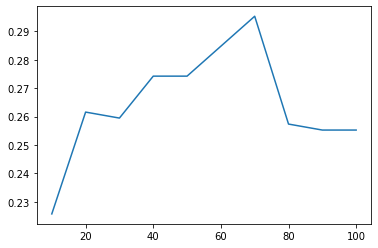

In [30]:
plt.plot(rank_list,AllHitrate)

In [ ]:
##Best Rank==70

#### SVD PredEval


In [132]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=70)
print(len(Vsvd_list))

10


In [133]:
Vsvd_last = Vsvd_list[-1]
Vsvd_last

array([[ 2.52465830e-06, -2.39704886e-04,  1.03121346e-03, ...,
         5.48022918e-10,  8.84752319e-10, -3.54033696e-08],
       [ 2.62720207e-05, -1.45760305e-05, -5.36633086e-04, ...,
        -2.47271955e-10,  6.68028386e-10, -2.82444440e-08],
       [-1.45282062e-04,  5.95159440e-04,  7.69668168e-04, ...,
         1.49198330e-07,  3.52620464e-07, -2.67741390e-07],
       ...,
       [ 1.91234867e-07, -1.55406575e-06,  5.54581134e-07, ...,
         2.87645739e-13,  8.51731986e-15, -3.67450004e-16],
       [ 1.95433367e-09, -5.44213811e-08,  4.74408769e-08, ...,
        -4.97039610e-17, -1.88676733e-16, -5.14630231e-18],
       [-9.56958812e-05,  8.02592590e-04,  5.97933171e-06, ...,
        -2.09547368e-10,  3.36571072e-10, -1.68180004e-11]])

In [135]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHoldout_list[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD  

(474, 10)


array([[ 558,   22,  995, ..., 3666,  488,  328],
       [4017, 1283, 2255, ..., 2736,  194, 4401],
       [ 389,  133,  598, ..., 1034,   82, 1310],
       ...,
       [ 251,  239, 1566, ...,  499, 1247, 1967],
       [ 319,  815,  422, ...,  588,  416,  854],
       [ 369,  158, 1628, ...,  328,  566,  219]])

In [136]:
Hitrate_Eval(newHoldout_list[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  141
Total Num of users:  474
Recommendation HitRate:  0.2974683544303797


0.2974683544303797

In [137]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHoldout_list,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

10it [00:00, 12.70it/s]10



[array([[ 558,   22,  995, ..., 3666,  488,  328],
        [4017, 1283, 2255, ..., 2736,  194, 4401],
        [ 389,  133,  598, ..., 1034,   82, 1310],
        ...,
        [ 251,  239, 1566, ...,  499, 1247, 1967],
        [ 319,  815,  422, ...,  588,  416,  854],
        [ 369,  158, 1628, ...,  328,  566,  219]]),
 array([[ 389,  133,  598, ...,   82, 1034, 1310],
        [ 231,  523, 1260, ..., 3026,  225,  226],
        [ 439,  922,  523, ...,   41,  191,  297],
        ...,
        [ 311,   85, 1230, ..., 2067, 3433, 4714],
        [ 427, 6134, 1435, ..., 2043, 1401, 6386],
        [  74, 2255,  231, ..., 3545, 2645,  566]])]

In [138]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHoldout_list,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  141
Total Num of users:  474
Recommendation HitRate:  0.2974683544303797
Number of hits:  139
Total Num of users:  433
Recommendation HitRate:  0.3210161662817552
Number of hits:  148
Total Num of users:  465
Recommendation HitRate:  0.31827956989247314
Number of hits:  152
Total Num of users:  478
Recommendation HitRate:  0.3179916317991632
Number of hits:  148
Total Num of users:  478
Recommendation HitRate:  0.30962343096234307
Number of hits:  152
Total Num of users:  508
Recommendation HitRate:  0.2992125984251969
Number of hits:  204
Total Num of users:  612
Recommendation HitRate:  0.3333333333333333
Number of hits:  164
Total Num of users:  599
Recommendation HitRate:  0.27378964941569284
Number of hits:  180
Total Num of users:  536
Recommendation HitRate:  0.3358208955223881
Number of hits:  81
Total Num of users:  425
Recommendation HitRate:  0.19058823529411764
Average HitRate for All Recommendations:  0.29971238653568427


In [143]:
AllSteps_Hitrate_svd  ##Rank == 70

[0.2974683544303797,
 0.3210161662817552,
 0.31827956989247314,
 0.3179916317991632,
 0.30962343096234307,
 0.2992125984251969,
 0.3333333333333333,
 0.27378964941569284,
 0.3358208955223881,
 0.19058823529411764]

In [144]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHoldout_list[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.2579038577456299


In [145]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHoldout_list,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  

10it [00:00, 748.88it/s]


[0.257904,
 0.265928,
 0.282022,
 0.277618,
 0.276946,
 0.262233,
 0.252534,
 0.238937,
 0.271409,
 0.152591]

In [ ]:
## AllSVD Prediction

In [147]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

10it [00:27,  2.77s/it]10



[array([[  63,   71,  205, ...,  215,  191,   50],
        [  60,  297,   43, ...,  928,  205,   57],
        [ 297,  242,  424, ...,  449,  928,  199],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]]),
 array([[  63,   71,  205, ...,  215,  191,   83],
        [  60,  297,   43, ...,  928,  205,   57],
        [ 297,  242,  424, ...,  199,  357,  928],
        ...,
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108],
        [2702, 2699, 2695, ..., 2705, 2706, 8108]])]

In [148]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_SVD_AllPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


In [7]:
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_SVD_AllPRED.pkl', 'rb') as f:
#      newSVDPred_LIST = pickle.load(f)
# newSVDPred_LIST     

In [151]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List  ##..Rank == 70

[0.079788,
 0.081021,
 0.079788,
 0.079295,
 0.079665,
 0.079048,
 0.080035,
 0.080035,
 0.079911,
 0.079418]

### CORRELATION Report


### getAll User Pred

In [174]:
# AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
# print(len(AllUsers_updtPRED))
# AllUsers_updtPRED[:2]

In [152]:
AllUsers_updtPRED[2].shape

(20149, 10)

####  Updated SingleRank Corr 

In [153]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

9
10


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [155]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.02499653,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.38792779, 0.67845367,
              0.        ])                                                    ,
       array([0.98387314, 1.        , 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.98387314, 0.94467132, 1.        , ..., 0.86813465, 0.4539545 ,
              0.        ])                                                    ,
       array([0.97749498, 0.9226361 , 1.        , ..., 0.49096051, 0.23150079,
              0.33050924])                                                    ,
       array([1.        , 1.        , 0.98387314, ..., 0.02499653, 0.08321104,
              0.        ])                                                    ,
       array([0.99056095, 1.        , 1.      

In [157]:
print(UpdtPSICorr_.shape)
print()
for df in UpdtPSICorr_:
    print(df.mean())  

(9,)

0.9507462669864827
0.9541200786395395
0.9462585543316474
0.954978187309988
0.9558312089585588
0.9507349839638036
0.9493731138244673
0.9385440611135092
0.9621093635351206


## RegPSI Corr_

AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 

print(len(AllUsersRegPIS_PRED))

AllUsersRegPIS_PRED[:2]

####  RegPSI SingleRankCorr 

In [158]:
AllSteps = list(range(1,10))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps  

9
10


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [159]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.02180383,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.49096051, 0.67845367,
              0.        ])                                                    ,
       array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.94467132, 1.        , ..., 0.86813465, 0.49096051,
              0.        ])                                                    ,
       array([1.        , 0.98788042, 1.        , ..., 0.41493338, 0.15058457,
              0.33050924])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.02180383, 0.08321104,
              0.        ])                                                    ,
       array([0.97749498, 1.        , 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
 

In [165]:
print(RegPSICorr_.shape)
print()
for df in RegPSICorr_:  ##Rank == 70
    print(df.mean())  

(9,)

0.9650199240782822
0.9654632087140693
0.9695926766281905
0.9686051221346264
0.9527405218684136
0.9601414867533916
0.9622915047414743
0.9439463379000846
0.9700566762443715


#### SVD Corr_

####  SVD SingleRankCorr 

In [162]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [163]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([0.93397092, 1.        , 0.91118591, ..., 0.        , 0.02928462,
              0.        ])                                                    ,
       array([0.87216233, 1.        , 1.        , ..., 0.49096051, 0.48421476,
              0.        ])                                                    ,
       array([0.88965694, 0.87216233, 0.90256476, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.61846289, 0.96643133, 0.95083917, ..., 0.36331733, 0.44498825,
              0.        ])                                                    ,
       array([0.87216233, 1.        , 0.88555371, ..., 0.49096051, 0.43767043,
              0.84271627])                                                    ,
       array([0.32979011, 0.44753873, 0.7685396 , ..., 0.15148206, 0.12147687,
              0.20133464])                                                    ,
       array([0.65474723, 0.74162341, 0.738546

In [166]:
print(pureSVDCorr_.shape)
print()
for df in pureSVDCorr_:  ##Rank == 70
    print(df.mean())  

(9,)

0.7276529488793384
0.7800912000874578
0.7950770993914437
0.7779707098984335
0.8316167535358526
0.6910707965040934
0.7405049881683469
0.7925807479319823
0.7955066322845123


###  RandRec:Test

In [194]:
def TopN_RandomPred_2(RatingMat,user_column,N):  
    N_users,N_items = RatingMat.shape   
    PVVT_RandScores = np.random.rand(N_users,N_items)   ##Assigns random scores to items
    users_column = RatingMat.nonzero()[0]
    items_column = RatingMat.nonzero()[1]
    args = np.array([users_column,items_column])
    np.put(PVVT_RandScores, np.ravel_multi_index(args, PVVT_RandScores.shape),-np.inf)   ##downsample previously 
    TopN_pred = np.apply_along_axis(topN_Index, 1,PVVT_RandScores,n = N)
    return TopN_pred

def get_ALLRandPred_2(RatingMat_List,user_column,N):
    All_RandPred = []
    for RatingMat in tqdm(RatingMat_List):  
        Rand_pred =  TopN_RandomPred_2(RatingMat,user_column, N)
        All_RandPred.append(Rand_pred)
    return All_RandPred

def getAll_RandomHitRate_2(HOLDOUT_list,All_RandPred,user_column,item_column):
    AllSteps_Hitrate = []
    for Holdout, Random_pred in zip(HOLDOUT_list,All_RandPred):  
        TestUsers = Holdout[user_column]
        HOLDOUT_RandPred = Random_pred[TestUsers,:]    
        HitRate_ = Hitrate_Eval(Holdout,HOLDOUT_RandPred,user_column,item_column)
        #HitRate_ = Sample_Hitrate(Holdout,HOLDOUT_RandPred,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)
    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand

    
def getAll_RandomRecMRR(HOLDOUT_list,All_RandPred,user_column,item_column):
    AllSteps_MRR = []
    for Holdout, Random_pred in tqdm(zip(HOLDOUT_list,All_RandPred)):  
        TestUsers = Holdout[user_column]
        HOLDOUT_RandPred = Random_pred[TestUsers,:]    
        MRR_ = MRR_Eval(Holdout,HOLDOUT_RandPred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand       



In [411]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

10 10


In [195]:
All_UsersRRecPred = get_ALLRandPred_2(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 10/10 [01:07<00:00,  6.71s/it]


[array([[7113, 1023, 4800, ..., 2370, 4504, 8050],
        [3656, 4990, 5604, ..., 7997, 6576, 5283],
        [5462, 5960,   57, ..., 6255, 3119, 1420],
        ...,
        [5281, 5435, 3735, ..., 1418, 2805, 5019],
        [4540, 1015,  955, ...,   51, 5749, 1866],
        [5736,  390, 6479, ...,  451, 2147, 4771]]),
 array([[5533,  646, 2750, ..., 6767, 4991, 5788],
        [6467, 7528, 2011, ..., 1509, 7335, 3460],
        [4100, 5937, 1909, ..., 5114,  952,  198],
        ...,
        [3719,  629,   96, ..., 4776, 4365, 6035],
        [ 534, 7773, 2771, ..., 4924,  266, 7755],
        [4278, 7374, 5239, ..., 6123, 3059,    7]])]

In [197]:
All_UsersRRecPred[1].shape

(22557, 10)

In [199]:
with open('RandRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


In [198]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate_2(newHOLDOUTDF_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  0
Total Num of users:  474
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  433
Recommendation HitRate:  0.0023094688221709007
Number of hits:  1
Total Num of users:  465
Recommendation HitRate:  0.002150537634408602
Number of hits:  1
Total Num of users:  478
Recommendation HitRate:  0.0020920502092050207
Number of hits:  0
Total Num of users:  478
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  508
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  612
Recommendation HitRate:  0.0
Number of hits:  0
Total Num of users:  599
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  536
Recommendation HitRate:  0.0018656716417910447
Number of hits:  0
Total Num of users:  425
Recommendation HitRate:  0.0
Average HitRate for All Recommendations:  0.0008417728307575569


In [200]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUTDF_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

10it [00:00, 252.23it/s]


[0, 0.00077, 0.00043, 0.000299, 0, 0, 0, 0, 0.000187, 0]

In [201]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZB_DF,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [202]:
#Stability: 
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [203]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.02499653, 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [204]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00034168174161810095
0.00041356184035532147
0.00037166892182754195
0.00036455975507635895
0.00034647512586037757
0.00039221420296906695
0.000405889395615047
0.0003310416333331755
0.0003389459917360753


In [208]:
newAMZB_DF['Updated_UserID'].nunique()
All_UsersRRecPred[0].shape

(22557, 10)

In [ ]:
newAMZB_DF['Updated_UserID'].nunique()
All_UsersRRecPred[0].shape

### Most Pop Rec

In [231]:

def getMOSTPOP_Pred(DF,user_column,item_colum,Nusers,N):  ##get the most popular item at a particular step
    top_counts= DF.groupby(item_colum)[user_column].count()    
    top_items = top_counts.sort_values(ascending=False) 
    MostPOP_Items = top_items[:N].index.values
    MostPOP_Pred = np.array([MostPOP_Items,]*Nusers)
    return MostPOP_Pred

def getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N):
    All_MostPOPRED_List = []
    for DF in DF_list:
        MostPOP_Pred = getMOSTPOP_Pred(DF,user_column,item_colum,Nusers,N)
        All_MostPOPRED_List.append(MostPOP_Pred) 
    return All_MostPOPRED_List

def getAll_MostPOPHitRate(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column):
    AllSteps_Hitrate = []
    for Holdout, MostPOP_pred in zip(HOLDOUT_list,All_MostPOPRED_List): 
        TestUsers = Holdout[user_column]
        Holdout_MPPred = MostPOP_pred[TestUsers,:]    
        HitRate_ = Hitrate_Eval(Holdout,Holdout_MPPred,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)
    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    


def getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column):
    AllSteps_MRR = []
    for Holdout, MostPOP_pred in tqdm(zip(HOLDOUT_list,All_MostPOPRED_List)): 
        TestUsers = Holdout[user_column]
        Holdout_MostPOPred =  MostPOP_pred[TestUsers,:]   
        MRR_ = MRR_Eval(Holdout,Holdout_MostPOPred,item_column)
        AllSteps_MRR.append(MRR_)
    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand 

In [224]:
Nusers = newAMZB_DF['Updated_UserID'].nunique() 
Nusers   

22557

In [226]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(new_PSIDFlist,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[239,  74,  67, ...,  24, 106, 426],
        [239,  74,  67, ...,  24, 106, 426],
        [239,  74,  67, ...,  24, 106, 426],
        ...,
        [239,  74,  67, ...,  24, 106, 426],
        [239,  74,  67, ...,  24, 106, 426],
        [239,  74,  67, ...,  24, 106, 426]]),
 array([[ 67, 251, 319, ..., 376,  24, 110],
        [ 67, 251, 319, ..., 376,  24, 110],
        [ 67, 251, 319, ..., 376,  24, 110],
        ...,
        [ 67, 251, 319, ..., 376,  24, 110],
        [ 67, 251, 319, ..., 376,  24, 110],
        [ 67, 251, 319, ..., 376,  24, 110]])]

In [227]:
All_MostPOPRED_List[1].shape

(22557, 10)

In [229]:
with open('MostPop_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


In [228]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  66
Total Num of users:  474
Recommendation HitRate:  0.13924050632911392
Number of hits:  93
Total Num of users:  433
Recommendation HitRate:  0.21478060046189376
Number of hits:  88
Total Num of users:  465
Recommendation HitRate:  0.18924731182795698
Number of hits:  83
Total Num of users:  478
Recommendation HitRate:  0.17364016736401675
Number of hits:  66
Total Num of users:  478
Recommendation HitRate:  0.13807531380753138
Number of hits:  72
Total Num of users:  508
Recommendation HitRate:  0.14173228346456693
Number of hits:  344
Total Num of users:  612
Recommendation HitRate:  0.5620915032679739
Number of hits:  115
Total Num of users:  599
Recommendation HitRate:  0.19198664440734559
Number of hits:  89
Total Num of users:  536
Recommendation HitRate:  0.166044776119403
Number of hits:  70
Total Num of users:  425
Recommendation HitRate:  0.16470588235294117
Average HitRate for All Recommendations:  0.20815449894027432


In [232]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUTDF_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR

10it [00:00, 362.79it/s]


[0.04406854865715625,
 0.07490285567652774,
 0.050268817204301076,
 0.04613053729162516,
 0.03268081291093843,
 0.05100456192975878,
 0.34897162568731194,
 0.048820123486233664,
 0.05733238569059465,
 0.04723809523809524]

In [233]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZB_DF,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233,
 0.001233]

In [234]:
#Stability: 
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [235]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.35282258, 0.35282258, 0.35282258, ..., 0.35282258, 0.35282258,
              0.35282258])                                                    ,
       array([0.33303233, 0.33303233, 0.33303233, ..., 0.33303233, 0.33303233,
              0.33303233])                                                    ,
       array([0.36900677, 0.36900677, 0.36900677, ..., 0.36900677, 0.36900677,
              0.36900677])                                                    ,
       array([0.37346483, 0.37346483, 0.37346483, ..., 0.37346483, 0.37346483,
              0.37346483])                                                    ,
       array([0.33182966, 0.33182966, 0.33182966, ..., 0.33182966, 0.33182966,
              0.33182966])                                                    ,
       array([0.14585112, 0.14585112, 0.14585112, ..., 0.14585112, 0.14585112,
              0.14585112])                                                    ,
       array([0.21208638, 0.21208638, 0.212086

In [237]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

0.3528225806451613
0.333032327975438
0.36900676991560805
0.37346483066617064
0.33182966438108974
0.14585112163315997
0.21208637819196985
0.15337135713727634
0.3545604698109744


In [419]:
## Multi VAE

In [7]:
from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
##Model

In [9]:
class Encoder(nn.Module):
    def __init__(self, q_dims, dropout):  ## q_dims: List[int], dropout: List[float]
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, p_dims, dropout):  #p_dims: List[int], dropout: List[float]
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h


class MultiVAE(nn.Module):
    def __init__(self,p_dims,q_dims,dropout_enc,dropout_dec): #p_dims:List[int],q_dims:List[int],dropout_enc:List[float],dropout_dec:List[float], 
        super().__init__()
        self.encode = Encoder(q_dims, dropout_enc)  #q_dims == Encoder dimensions
        self.decode = Decoder(p_dims, dropout_dec)  #p_dims == Decoder dimensions

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar        

def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]

#Recall = (Relevant_Items_Recommended in top-k)/(Relevant_Items)



In [ ]:
##Train and Eval...

In [15]:
def train_step(model, optimizer, data, epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(training_steps), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
            anneal = anneal_cap
        else:
            anneal = min(anneal_cap, update_count / total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)


def eval_step(model,data_tr, data_te):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, r20_list, r50_list = [], [], []
    #with trange(eval_steps) as t:
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             loss = vae_loss_fn(X_tr_inp, X_out, mu, logvar, train_step.anneal)
             running_loss += loss.item()
             avg_loss = running_loss / (batch_idx + 1)

             #Exclude examples from training set
             X_out = X_out.cpu().numpy()
             X_out[X_tr.nonzero()] = -np.inf

             n100 = NDCG_binary_at_k_batch(X_out, X_te, k=100)
             r50 = Recall_at_k_batch(X_out, X_te, k=50)
             #r20 = Recall_at_k_batch(X_out, X_te, k=20)

             r50_list.append(r50)
             n100_list.append(n100)
             #r20_list.append(r20)
                

    n100_list = np.concatenate(n100_list)
    r50_list = np.concatenate(r50_list)
    #r20_list = np.concatenate(r20_list)
    return avg_loss, np.mean(n100_list), np.mean(r50_list)  #, np.mean(r50_list)

In [17]:
def getTot_annealSTeps(train_RatMat,batch_size,n_epochs,anneal_cap):
    training_steps = len(range(0, train_RatMat.shape[0], batch_size))
    try:
       total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.2))) / anneal_cap  ##
    except ZeroDivisionError:
        assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

    return total_anneal_steps

#############################################
def early_stop(curr_value, best_value, stop_step, patience, score_fn='metric'):
    if (score_fn == "loss" and curr_value <= best_value) or (score_fn == "metric" and curr_value >= best_value):
        stop_step, best_value = 0, curr_value
    else:
        stop_step += 1
    if stop_step >= patience:
        print("Early stopping triggered. patience: {} log:{}".format(patience, best_value))
        stop = True
    else:
        stop = False
    return best_value, stop_step, stop 

def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)
  


In [478]:
training_steps = len(range(0, TrainDF_RatMat.shape[0], batch_size))
try:
   total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.15))) / anneal_cap
except ZeroDivisionError:
   assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"
total_anneal_steps

In [10]:
newAMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_afterUpdt.csv') 
newAMZB_DF['timestamp'] = pd.to_datetime(newAMZB_DF['timestamp']) 
print(newAMZB_DF.shape)   #userId_int
#print(newAMZB_DF.dtypes)
newAMZB_DF.head()

(51277, 7)


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
0,0,0,1,2001-06-08,2001-06,0,0
1,1,0,1,2002-06-12,2002-06,1,0
2,1,1,1,2002-06-12,2002-06,1,1
3,2,1,1,2002-06-17,2002-06,2,1
4,3,1,1,2002-07-04,2002-07,3,1


In [17]:
newAMZB_DF['Updated_UserID'].nunique()

22557

In [17]:
raw_data = newAMZB_DF
user_activity =   raw_data['Updated_UserID'].unique()
item_popularity = raw_data['Updated_ItemID'].unique()
print(user_activity.shape)
print(item_popularity.shape)
print()
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

(22557,)
(8109,)

After filtering, there are 51277 watching events from 22557 users and 8109 movies (sparsity: 0.028%)


In [18]:
unique_uid = user_activity
train_users, valid_users, test_users = split_users(raw_data,'Updated_UserID',n_heldout_users=2500)
print(train_users.shape)
train_users

(17557,)


array([ 3378, 16041, 13632, ..., 19635, 17973, 21397])

In [253]:
print(valid_users.shape)
valid_users

(2500,)


array([13506, 14933, 11471, ..., 12904, 13868,  3810])

In [452]:
print(test_users.shape)
test_users

(2500,)


array([9731, 4164, 7504, ..., 9580, 3571, 3861])

In [19]:
##train data observation...
train_df = raw_data.loc[raw_data['Updated_UserID'].isin(train_users)]
print(train_df['Updated_UserID'].nunique())
train_df.sample(10)

17557


,userId,productId,rating,timestamp,timestamp_YM,Updated_UserID,Updated_ItemID
27502,13841,311,1,2015-09-05,2015-09,13841,311
8205,4289,67,1,2013-02-08,2013-02,4289,67
11471,5917,74,1,2013-08-16,2013-08,5917,74
7743,4049,67,1,2013-01-14,2013-01,4049,67
50030,17033,4383,1,2018-03-01,2018-03,17033,4383
49030,701,8224,1,2017-11-20,2017-11,701,7818
40177,19134,3755,1,2016-09-16,2016-09,19134,3755
44936,20929,6848,1,2017-03-25,2017-03,20548,6726
9187,4777,24,1,2013-04-03,2013-04,4777,24
49847,22411,55,1,2018-02-12,2018-02,22033,55


In [21]:
### items used in the training data...
train_Items = pd.unique(train_df['Updated_ItemID'])  #unique_sid == train_Items
print(len(train_Items))
train_Items

6961


array([   0,    1,    2, ..., 8041, 5938, 7167])

In [22]:
# Save index dictionaries to "numerise" later one
unique_uid = user_activity
item2id = dict((sid, i) for (i, sid) in enumerate(train_Items))
user2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))
print(len(item2id))
print(len(user2id))

6961
22557


In [23]:
          #for validation and test they consider "only" items that have been seen during training
valid_df = raw_data[raw_data["Updated_UserID"].isin(valid_users)& raw_data["Updated_ItemID"].isin(train_Items)]  #vd_obsrv 
test_df = raw_data[raw_data["Updated_UserID"].isin(test_users) & raw_data["Updated_ItemID"].isin(train_Items)]  #te_obsr
print("Validation Set")
print(valid_df['Updated_UserID'].nunique())
print(valid_df.shape)
print()
print("Test Set")
print(test_df['Updated_UserID'].nunique())
print(test_df.shape)

Validation Set
2429
(5089, 7)

Test Set
2421
(5061, 7)


In [24]:
valid_trn, valid_tst = split_train_test(valid_df, test_prop=0.3)
print(valid_trn.shape, valid_tst.shape) 

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
(4931, 7) (158, 7)


In [25]:
test_train, test_tst = split_train_test(test_df, test_prop=0.3)
print(test_train.shape, test_tst.shape)   ##

0 users sampled
250 users sampled
500 users sampled
750 users sampled
1000 users sampled
1250 users sampled
1500 users sampled
1750 users sampled
2000 users sampled
2250 users sampled
(4903, 7) (158, 7)


In [26]:
Train_DF   =    numerize_data(train_df,user2id,item2id, 'Updated_UserID','Updated_ItemID')
ValidTrain_DF = numerize_data(valid_trn,user2id,item2id,'Updated_UserID','Updated_ItemID')
ValidTest_DF = numerize_data(valid_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTrain_DF = numerize_data(test_train,user2id,item2id, 'Updated_UserID','Updated_ItemID')
TestTest_DF =  numerize_data(test_tst,user2id,item2id, 'Updated_UserID','Updated_ItemID')

print("Training Data: ",Train_DF.shape)
print()
print("Validaion DF: ", ValidTrain_DF.shape,ValidTest_DF.shape)
print("Test DF:      ", TestTrain_DF.shape,TestTest_DF.shape)

Training Data:  (39893, 2)

Validaion DF:  (4931, 2) (158, 2)
Test DF:       (4903, 2) (158, 2)


In [27]:
n_items = len(train_Items)                            #train_Items = unique_sid
TrainDF_RatMat = get_TrainRatMat(Train_DF,'Updated_UserID','Updated_ItemID',n_items)
ValidTrain_RatMat, ValidTest_RatMat = getTrainTest_RatMat(ValidTrain_DF, ValidTest_DF,'Updated_UserID','Updated_ItemID',n_items)
TestTrain_RatMat, TestTest_RatMat = getTrainTest_RatMat(TestTrain_DF, TestTest_DF,'Updated_UserID','Updated_ItemID',n_items)

TrainDF_RatMat

<22557x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 39505 stored elements in Compressed Sparse Row format>

In [461]:
ValidTrain_RatMat

<22543x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 4872 stored elements in Compressed Sparse Row format>

In [263]:
ValidTest_RatMat

<22543x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 158 stored elements in Compressed Sparse Row format>

In [465]:
TestTrain_RatMat

<22517x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 4852 stored elements in Compressed Sparse Row format>

In [466]:
TestTest_RatMat

<22517x6961 sparse matrix of type '<class 'numpy.float64'>'
	with 158 stored elements in Compressed Sparse Row format>

In [16]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):  #Hello2021
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    denominator = np.minimum(k, X_true_binary.sum(axis=1))
    recall = tmp[denominator > 0.0] / denominator[denominator > 0.0]
    return recall

def HR_at_k_batch(pred_scores, ground_truth, k=10):  #"pred_scores' and 'ground_truth' must have the same shape."
    k = min(pred_scores.shape[1], k)
    idx = bn.argpartition(-pred_scores, k-1, axis=1)
    pred_scores_binary = np.zeros_like(pred_scores, dtype=bool)
    pred_scores_binary[np.arange(pred_scores.shape[0])[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (ground_truth > 0)
    num = (np.logical_and(X_true_binary, pred_scores_binary).sum(axis=1)).astype(np.float32)
    return num > 0
   
def MRR_at_k_batch(pred_scores, ground_truth, k=10):  #'pred_scores' and 'ground_truth' must have the same shape
       #Compute the Mean Reciprocal Rank (MRR)             
    k = min(pred_scores.shape[1], k)
    idx = np.argsort(-pred_scores)
    hits = ground_truth[np.arange(ground_truth.shape[0])[:, np.newaxis], idx[:, :k]]
    rranks, cranks = hits.nonzero()

    mrr = [0. for _ in range(ground_truth.shape[0])]
    for i, r in enumerate(rranks):
        if mrr[r] == 0:
           mrr[r] = 1. / (1 + cranks[i])

    return np.array(mrr)

In [39]:
   
def get_eval(model,data_tr):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()     #X_out[X_tr.nonzero()] = -np.inf 
            
             n100 =  NDCG_binary_at_k_batch(X_out, X_tr, k=100)
             hr10 =  HR_at_k_batch(X_out, X_tr.toarray(), k=10)   # #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_tr.toarray(), k=10)

             n100_list.append(n100)   
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    n100_list = np.concatenate(n100_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    return np.mean(n100_list), np.mean(hr10_list), np.mean(mrr10_list)


def getPred_(model,data_tr,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             topN_pred = TopNPred(data_tr,X_out,k)
             #topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
    return AllUserPRED 


In [ ]:
##All stepp Prediction

In [32]:
def get_holdoutRatMat(Holdout_MATList,newHoldout_list):
    HOLDOUT_MATList = []
    for holdoutMAT, holdout_df in zip(Holdout_MATList,newHoldout_list):
        heldout_users = holdout_df['Updated_UserID']
        Holdout_Mat = holdoutMAT[heldout_users,:] 
        HOLDOUT_MATList.append(Holdout_Mat)
    return  HOLDOUT_MATList

 

In [11]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newPSITest.pkl', 'rb') as f:
     newPSITest_list = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [12]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

10


[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [34]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
holdout_MATList_1 = AllRatingMatrices(newHoldout_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 

HOLDOUT_MATList = get_holdoutRatMat(holdout_MATList_1,newHoldout_list)
print(len(HOLDOUT_MATList))   
HOLDOUT_MATList  

10


[<474x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 474 stored elements in Compressed Sparse Row format>,
 <433x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 433 stored elements in Compressed Sparse Row format>,
 <465x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 465 stored elements in Compressed Sparse Row format>,
 <478x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 478 stored elements in Compressed Sparse Row format>,
 <478x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 478 stored elements in Compressed Sparse Row format>,
 <508x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 508 stored elements in Compressed Sparse Row format>,
 <612x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 612 stored elements in Compressed Sparse Row format>,
 <599x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 599 stored elements in Compressed Sparse Row format>,
 <536x8109 sparse matrix of type '<class

In [173]:
I =  newAMZB_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=8109, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=8109, bias=True)
    )
  )
)

In [23]:
 total_anneal_steps = getTot_annealSTeps(UserItem_MATList[0],batch_size,n_epochs,anneal_cap)
 total_anneal_steps

90400.0

In [176]:
batch_size = 200
anneal_cap = 0.2
best_score = -np.inf
update_count = 0
n_epochs = 200
constant_anneal = False
total_anneal_steps = 100000

In [169]:
for epoch in tqdm(range(50)):
    train_step(VAEmodel, optimizer, UserItem_MATList[0], epoch)


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


In [177]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  

def getall_UsersPred(model,data_tr,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
         
    return AllUserPRED 
 

   #getmetrics_(model_,holdout_Mat,holdout_df,batch_size=holdout_Mat.shape[0],k)
def getmetrics_(model,data_tr,holdout_df,batch_size,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()        
             #topN_pred = TopNPred(holdout_df,X_out,k)
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = k)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
    hr_value = Hitrate_Eval(holdout_df,AllUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,AllUserPRED,'Updated_ItemID') 
    return hr_value,mrr_value     

def singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k=10):
    for epoch in range(n_epoch):
        train_step(model_, optimizer, UserItemMat, epoch)
    
    hr10,mrr10 = getmetrics_(model_,holdout_Mat,holdout_df,holdout_Mat.shape[0],k)
    allUserPRED = getall_UsersPred(model_,UserItemMat,pred_BS,k)
    return  hr10,mrr10,allUserPRED

def Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_Mat,holdout_df in tqdm(zip(UserItemMatList,holdout_MatList,newHoldoutList)):
        hr10,mrr10,allUserpred_ = singlestep_predEval(model_,UserItemMat,holdout_Mat,holdout_df,pred_BS,n_epoch,k)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUserpred_)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))
    return hr10_List,mrr10_List ,ALLUsers_Pred    

In [171]:
 n100, hr10,mrr10 = get_eval(VAEmodel,HOLDOUT_MATList[0])
 print(n100, hr10,mrr10)

0.920143720761297 0.989451476793249 0.8925808720112517


In [189]:
I =  newAMZB_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
#I = len(train_Items) 
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=8109, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=8109, bias=True)
    )
  )
)

In [190]:
                                      #Allsteps_predEval(model_,UserItemMatList,holdout_MatList,newHoldoutList, pred_BS,n_epoch,k=10)
hr10_List,mrr10_List ,ALLUsersPred_2 = Allsteps_predEval(VAEmodel,UserItem_MATList,HOLDOUT_MATList,newHoldout_list,pred_BS=2000,n_epoch=50,k=10)

0it [00:00, ?it/s]Number of hits:  470
Total Num of users:  474
Recommendation HitRate:  0.9915611814345991
1it [00:55, 55.12s/it]| HitRate  0.992 | Mrr 0.869 | 
Number of hits:  426
Total Num of users:  433
Recommendation HitRate:  0.9838337182448037
2it [01:48, 54.39s/it]| HitRate  0.984 | Mrr 0.893 | 
Number of hits:  458
Total Num of users:  465
Recommendation HitRate:  0.9849462365591398
3it [02:43, 54.40s/it]| HitRate  0.985 | Mrr 0.858 | 
Number of hits:  470
Total Num of users:  478
Recommendation HitRate:  0.9832635983263598
4it [03:38, 54.54s/it]| HitRate  0.983 | Mrr 0.877 | 
Number of hits:  472
Total Num of users:  478
Recommendation HitRate:  0.9874476987447699
5it [04:33, 54.72s/it]| HitRate  0.987 | Mrr 0.900 | 
Number of hits:  503
Total Num of users:  508
Recommendation HitRate:  0.9901574803149606
6it [05:28, 55.04s/it]| HitRate  0.990 | Mrr 0.906 | 
Number of hits:  606
Total Num of users:  612
Recommendation HitRate:  0.9901960784313726
7it [06:23, 55.03s/it]| HitR

In [191]:
hr10_List

[0.9915611814345991,
 0.9838337182448037,
 0.9849462365591398,
 0.9832635983263598,
 0.9874476987447699,
 0.9901574803149606,
 0.9901960784313726,
 0.986644407345576,
 0.9925373134328358,
 0.9811764705882353]

In [192]:
mrr10_List

[0.8687060478199718,
 0.8929396238865062,
 0.858458781362007,
 0.8768828451882845,
 0.9001046025104602,
 0.906003937007874,
 0.9272875816993464,
 0.8929883138564273,
 0.8885261194029851,
 0.9104901960784313]

In [198]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_20VAE_allPRED_NEW.pkl', 'wb') as f:  
     pickle.dump(ALLUsersPred_2, f)

In [193]:
ALLUsersPred_2[:2]

[array([[  60,    0,   43, ...,   21,   57,  737],
        [   1,    0,   62, ...,    2, 3204, 3013],
        [   1,   62,    0, ..., 5034, 3695,   60],
        ...,
        [  67,   74,  107, ...,  692,  555,  995],
        [  67,   74,  107, ...,  692,  555,  995],
        [  67,   74,  107, ...,  692,  555,  995]]),
 array([[  60,    0,   43, ...,   57,  381,   21],
        [   1,    0,   62, ..., 3583, 3204,  199],
        [   1,   62,    9, ...,    2,   60, 2577],
        ...,
        [  67,   74,  106, ...,  239, 1230,  555],
        [  67,   74,  106, ...,  239, 1230,  555],
        [  67,   74,  106, ...,  239, 1230,  555]])]

In [195]:
VAE_CovList = AllSteps_Coverage_Ratio(newAMZB_DF,ALLUsersPred_2,'Updated_ItemID')
VAE_CovList

[0.802318,
 0.823776,
 0.84548,
 0.865951,
 0.888889,
 0.914663,
 0.940437,
 0.953755,
 0.973856,
 0.997287]

In [186]:
AllSteps = list(range(1,10))
print(len(AllSteps))   #Hello2021
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [196]:
VAECorr_ = Updt_getAll_AvgCorr(ALLUsersPred_2,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.712529  , 0.82765878, 0.7153149 , ..., 0.08012   , 0.73222248,
              0.2040783 ])                                                    ,
       array([0.43767043, 0.82765878, 0.41778717, ..., 0.6254129 , 0.09331951,
              0.59039   ])                                                    ,
       array([0.51560575, 0.50909834, 0.67902639, ..., 0.        , 0.09754647,
              0.06677266])                                                    ,
       array([0.74884492, 0.52264054, 0.51841185, ..., 0.66783414, 0.64644211,
              0.37936834])                                                    ,
       array([0.74656886, 0.64314337, 0.45252386, ..., 0.35059469, 0.16806457,
              0.22121112])                                                    ,
       array([0.67047641, 0.80266211, 0.77300024, ..., 0.5327588 , 0.34322111,
              0.42065249])                                                    ,
       array([0.54220644, 0.72735783, 0.505865

In [199]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())    

(9,)
0.4980823820124463
0.5728869763525876
0.5205820696074656
0.517132851872847
0.454360389003563
0.5259238717380633
0.4795210300395967
0.4934513004033183
0.536089021716472


In [42]:
from tqdm import trange

In [28]:
als_params = dict(batch_size = [50,100,200,300,500],
                  lr = [1e-7,1e-5,1e-3,1e-1],
                  weight_decay= [0.,0.1,0.2,0.3])

als_param_grid, als_param_names = random_grid(als_params, n=50)
print(als_param_names)
len(als_param_grid)                 

('batch_size', 'lr', 'weight_decay')


50

In [31]:
for i in range(10):
    batch_size, lr, weight_decay = list(als_param_grid)[i]  
    print(batch_size, lr, weight_decay)

200 1e-05 0.1
100 1e-07 0.1
50 1e-05 0.2
200 0.001 0.2
300 1e-07 0.0
300 0.1 0.3
50 1e-07 0.0
50 0.1 0.3
100 0.001 0.2
100 1e-05 0.1


In [271]:
200 1e-05 0.1
50 1e-05 0.2
200 0.001 0.2
300 1e-05 0.2
50 0.001 0.2
50 1e-07 0.0
500 1e-05 0.0
50 0.1 0.3
100 0.001 0.2
100 1e-05 0.1
300 0.001 0.2
200 1e-05 0.0
500 0.1 0.2
300 1e-05 0.1
200 0.001 0.1
100 0.1 0.2
50 0.001 0.1
200 0.1 0.1
100 0.001 0.1
500 0.001 0.0

6961

In [47]:
def early_stop(curr_value, best_value, stop_step, patience):
    if  curr_value >= best_value:
        stop_step =0
        best_value = curr_value
    else:
        stop_step += 1
    if stop_step >= patience:
        print("Early stopping triggered. patience: {} log:{}".format(patience, best_value))
        stop = True
    else:
        stop = False
    return best_value, stop_step, stop 

def tuning_2(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= True):
    stop_step = 0
    for i in trange(10):   #len(als_param_grid)
        batch_size, lr_, weightdecay_ = list(als_param_grid)[i]
        total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
        Optimizer_ = torch.optim.AdamW(model.parameters(), lr=lr_, weight_decay=weightdecay_)
        print('batch_size = {} ,learning_rate = {}, weight_decay = {} '.format(batch_size,lr_,weightdecay_))
        model_2 = model
        best_score = 0     ##based on MetricEval..
        stop = False
        for epoch in range(n_epochs):            
            train_step_2(model_2, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_2,validtrain_set,validtest_set)
            curr_score = NDCG100_
            best_score,stop_step,stop = early_stop(curr_score,best_score,stop_step,patience=20)
            if stop:
                break
            if (stop_step == 0) & (save_results):
               best_epoch = epoch
               best_BS  = batch_size
               best_lr_ = lr_
               best_weightdecay_ = weightdecay_
               best_NGCG100 = NDCG100_
               torch.save(model_2.state_dict(),model_name+".pth")
               #print('NDCG100_ = {}, epoch = {}, best_score = {} '.format(best_NGCG100,best_epoch,best_score))
               
        print('NDCG100_ = {} '.format(best_NGCG100))

    print('\n Best parameters; batch_size= {}, learning_rate = {}, weight_decay = {}, NDCG100_ = {}, best_epoch = {}'.format(best_BS, best_lr_,best_weightdecay_,best_NGCG100,best_epoch))
    return best_BS, best_lr_, best_weightdecay_,best_NGCG100, best_epoch  

In [84]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=6961, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=6961, bias=True)
    )
  )
)

In [76]:
# update_count = 0 
# anneal_epochs = None  
# anneal_cap = 0.2
# constant_anneal = False
# patience = 10
# total_anneal_steps = getTot_annealSTeps(TrainDF_RatMat,200,50,anneal_cap)
# Optimizer_ = torch.optim.AdamW(VAEmodel.parameters(), lr=0.001, weight_decay=0.2)
# best_NDCG = 0     
# #model_name = 'AMZBVAE_2'
# for epoch in trange(50):            
#     train_step_2(VAEmodel, Optimizer_, TrainDF_RatMat,total_anneal_steps,epoch)
#     val_loss, NDCG100_ = eval_step_2(VAEmodel,ValidTrain_RatMat,ValidTest_RatMat)
#     print(NDCG100_)
#     curr_score = NDCG100_
#     if curr_score > best_NDCG:
#        best_NDCG = curr_score
#        best_epoch = epoch
#        #torch.save(VAEmodel.state_dict(),model_name+".pth")

#     if (epoch >= best_epoch+patience) & (curr_score < best_NDCG):
#         print("Early Stop Activated")
#         break
    
#     print('Curr_score = {}, Best_score = {} , Epoch = {} '.format(curr_score,best_NDCG,epoch))

In [62]:
#batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 ,n_epochs_ = 50
total_anneal_steps = getTot_annealSTeps(TrainDF_RatMat,200,50,anneal_cap)
Optimizer_ = torch.optim.AdamW(VAEmodel.parameters(), lr=0.001, weight_decay=0.2)
best_NDCG = 0     
model_name = 'AMZBVAE_2'
for epoch in trange(50):            
    train_step_2(VAEmodel, Optimizer_, TrainDF_RatMat,total_anneal_steps,epoch)
    val_loss, NDCG100_ = eval_step_2(VAEmodel,ValidTrain_RatMat,ValidTest_RatMat)
    print(NDCG100_)
    curr_score = NDCG100_
    if curr_score > best_NDCG:
       best_NDCG = curr_score
       torch.save(VAEmodel.state_dict(),model_name+".pth")
    
    print('Curr_score = {}, Best_score = {} '.format(curr_score,best_NDCG))

  2%|▏         | 1/50 [00:06<05:05,  6.23s/it]0.6585828697189701
Curr_score = 0.6585828697189701, Best_score = 0.6585828697189701 
  4%|▍         | 2/50 [00:12<05:10,  6.47s/it]0.6674166300370469
Curr_score = 0.6674166300370469, Best_score = 0.6674166300370469 
  6%|▌         | 3/50 [00:19<05:11,  6.62s/it]0.6681812943726724
Curr_score = 0.6681812943726724, Best_score = 0.6681812943726724 
  8%|▊         | 4/50 [00:25<04:54,  6.41s/it]0.6640851603642662
Curr_score = 0.6640851603642662, Best_score = 0.6681812943726724 
 10%|█         | 5/50 [00:32<04:55,  6.56s/it]0.6841801532017329
Curr_score = 0.6841801532017329, Best_score = 0.6841801532017329 
 12%|█▏        | 6/50 [00:39<04:51,  6.63s/it]0.6847280249463524
Curr_score = 0.6847280249463524, Best_score = 0.6847280249463524 
 14%|█▍        | 7/50 [00:46<04:48,  6.70s/it]0.6799999163191904
Curr_score = 0.6799999163191904, Best_score = 0.6847280249463524 
 16%|█▌        | 8/50 [00:52<04:31,  6.46s/it]0.676198624886627
Curr_score = 0.6761

In [63]:
best_NDCG

0.7153988414708565

In [77]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('AMZBVAE_2.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.7255124902637974

In [484]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0

#tuning_2(model,train_set,validtrain_set,validtest_set,als_param_grid,n_epochs,model_name,save_results= True)
bestModel_info =  tuning_2(VAEmodel,TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,als_param_grid,200,"AMZB_VAE",save_results= True)

  2%|▏         | 1/50 [11:23<9:17:56, 683.19s/it]Early stopping triggered. patience: 25 log:0.6412730657920738
NDCG100_ = 0.6412730657920738 
batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 
  4%|▍         | 2/50 [11:30<3:48:24, 285.51s/it]Early stopping triggered. patience: 25 log:0.6412730657920738
NDCG100_ = 0.6412730657920738 
batch_size = 300 ,learning_rate = 1e-07, weight_decay = 0.0 
  6%|▌         | 3/50 [11:37<2:04:05, 158.41s/it]Early stopping triggered. patience: 25 log:0.6412730657920738
NDCG100_ = 0.6412730657920738 
batch_size = 100 ,learning_rate = 0.1, weight_decay = 0.3 
  8%|▊         | 4/50 [11:43<1:15:10, 98.06s/it] Early stopping triggered. patience: 25 log:0.6412730657920738
NDCG100_ = 0.6412730657920738 
batch_size = 50 ,learning_rate = 1e-07, weight_decay = 0.0 
 10%|█         | 5/50 [11:48<48:36, 64.81s/it]  Early stopping triggered. patience: 25 log:0.6412730657920738
NDCG100_ = 0.6412730657920738 
batch_size = 50 ,learning_rate = 0.001, weight_dec

In [485]:
best_BS, best_lr_, best_weightdecay_,best_NGCG100, best_epoch =  bestModel_info
print("batch_size     :",best_BS)
print("learning_rate  :",best_lr_)
print("weight_decay   :",best_weightdecay_)
print("best_NGCG100   :",best_NGCG100)        
print("best_epoch      :",best_epoch)

batch_size     : 200
learning_rate  : 1e-05
weight_decay   : 0.1
best_NGCG100   : 0.6412730657920738
best_epoch      : 72


In [69]:
#batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 ,n_epochs_ = 50
print("batch_size     :",200)
print("learning_rate  :",0.001)
print("weight_decay   :",0.2 )
print("best_NGCG100   :",best_NGCG)        
#print("best_epoch      :",best_epoch)

In [486]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('AMZB_VAE.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.6652911149722905

In [ ]:
##P_Dimension Tuning

In [85]:
def getVAEModel(n_items,p_dims):
    I = n_items    #I is the total number of items in the train date
    q_Dims = [I] + p_dims[::-1]
    P_Dims = p_dims + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0.5]

    VAEmodel = MultiVAE(P_Dims,q_Dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    return VAEmodel

def P_dimsTuning(train_set,validtrain_set,validtest_set,n_items,p_dimsList,model_name,n_epochs,save_results= True):
    update_count = 0
    best_NDCG = 0     
    update_count = 0
    total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
    for p_dims in tqdm(p_dimsList):
        print("P_Dimensions: ",p_dims)
        model_ = getVAEModel(n_items,p_dims) 
        Optimizer_ = torch.optim.AdamW(model_.parameters(), lr=lr_, weight_decay=weightdecay_)
        for epoch in range(n_epochs):            
            train_step_2(model_, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_,validtrain_set,validtest_set)
            curr_score = NDCG100_
            if curr_score > best_NDCG:
               best_NDCG = curr_score
               best_dims = p_dims
               torch.save(VAEmodel.state_dict(),model_name+".pth")
    
        print('Curr_score = {}, Best_score = {},Best_P_dims = {} '.format(curr_score,best_NDCG,best_dims))
        
        
    print('\n Best parameters; Best_dims= {}, Best_NDCG100 = {}'.format(best_dims,best_NDCG))
    return best_NDCG,best_dims  


def epoch_Tuning(train_set,validtrain_set,validtest_set,n_items,p_dimsList,model_name,n_epochs,save_results= True):
    update_count = 0
    best_NDCG = 0     
    update_count = 0
    total_anneal_steps = getTot_annealSTeps(train_set,batch_size,n_epochs,anneal_cap)
    for p_dims in tqdm(p_dimsList):
        print("P_Dimensions: ",p_dims)
        model_ = getVAEModel(n_items,p_dims) 
        Optimizer_ = torch.optim.AdamW(model_.parameters(), lr=lr_, weight_decay=weightdecay_)
        for epoch in range(n_epochs):            
            train_step_2(model_, Optimizer_, train_set,total_anneal_steps,epoch)
            val_loss, NDCG100_ = eval_step_2(model_,validtrain_set,validtest_set)
            curr_score = NDCG100_
            if curr_score > best_NDCG:
               best_NDCG = curr_score
               best_dims = p_dims
               torch.save(VAEmodel.state_dict(),model_name+".pth")
    
        print('Curr_score = {}, Best_score = {},Best_P_dims = {} '.format(curr_score,best_NDCG,best_dims))
        
        
    print('\n Best parameters; Best_dims= {}, Best_NDCG100 = {}'.format(best_dims,best_NDCG))
    return best_NDCG,best_dims  



In [86]:
#batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 ,n_epochs_ = 50
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
batch_size=200
lr_= 0.001
weightdecay_=0.2
n_items = len(train_Items) 
p_dimsList  = [[32,64],[64,128],[128,256],[256,512],[512,1024],[100,300],[200,600],[300,900]]

best_ModelInfo2 = P_dimsTuning(TrainDF_RatMat,ValidTrain_RatMat,ValidTest_RatMat,n_items,p_dimsList,"AMZB_DimModel",n_epochs=50,save_results= True)

 12%|█▎        | 1/8 [04:29<31:25, 269.32s/it]Curr_score = 0.5837287655464903, Best_score = 0.6120070681164448,Best_P_dims = [32, 64] 
P_Dimensions:  [64, 128]
 25%|██▌       | 2/8 [09:07<27:25, 274.31s/it]Curr_score = 0.6666002005948007, Best_score = 0.6716524707237834,Best_P_dims = [64, 128] 
P_Dimensions:  [128, 256]
 38%|███▊      | 3/8 [13:23<22:09, 265.95s/it]Curr_score = 0.6852466735557055, Best_score = 0.6875681265085664,Best_P_dims = [128, 256] 
P_Dimensions:  [256, 512]
 50%|█████     | 4/8 [17:16<16:52, 253.10s/it]Curr_score = 0.6811728918212387, Best_score = 0.6993992422948409,Best_P_dims = [256, 512] 
P_Dimensions:  [512, 1024]
 62%|██████▎   | 5/8 [21:32<12:42, 254.23s/it]Curr_score = 0.6970349825603533, Best_score = 0.7055693200112986,Best_P_dims = [512, 1024] 
P_Dimensions:  [100, 300]
 75%|███████▌  | 6/8 [25:30<08:17, 248.72s/it]Curr_score = 0.6866653139930067, Best_score = 0.7055693200112986,Best_P_dims = [512, 1024] 
P_Dimensions:  [200, 600]
 88%|████████▊ | 7/8 [2

In [94]:
n_items = len(train_Items)   
I = n_items    ##I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.5]
                    
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=6961, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.5, inplace=False)
      (linear_1): Linear(in_features=600, out_features=6961, bias=True)
    )
  )
)

In [122]:
# Run on test data with best model
#model.load_state_dict(torch.load(model_name + ".pt")))
VAEmodel.load_state_dict(torch.load('AMZBVAE_2.pth'))
test_loss,tst_ndgc100_ = eval_step_2(VAEmodel,TestTrain_RatMat,TestTest_RatMat)
tst_ndgc100_

0.7255124902637974

In [18]:
 import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newPSITest.pkl', 'rb') as f:
     newPSITest_list = pickle.load(f)     

    
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)

In [19]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItem_MATList   

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

In [20]:
 I =  newAMZB_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodel_untrain = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel_untrain)
VAEmodel_untrain.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=8109, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=8109, bias=True)
    )
  )
)

In [21]:
device

device(type='cuda')

In [104]:
# newHoldout_List[0]  newPSITest_List

In [24]:
def Trainwith_Best(model,UserItem_TRset,best_BS,best_lr,best_wd):
    total_anneal_steps = getTot_annealSTeps(UserItem_TRset,best_BS,anneal_n,anneal_cap)
    Optimizer_ = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_wd)
    for epoch in tqdm(range(bst_epochs)):            
        train_step_2(model, Optimizer_, UserItem_TRset,total_anneal_steps,epoch)
      
    #torch.save(model.state_dict(),model_name+".pth")
    return model

def get_ModelOut(X_train,model):  #X_train== RatMat...
    with torch.no_grad():
         X_input = torch.FloatTensor(X_train.toarray()).to(device)
         X_out, mu, logvar = model(X_input)
         X_out = X_out.cpu().numpy()         #convert from tensor to numpy
         #X_out[X_train.nonzero()] = -np.inf  #Exclude examples from training set
    return X_out


def getVAE_TopNPred(X_out,k):   ##X_out == tensor output from model
    batch_users = X_out.shape[0]
    idx_topk_part = bn.argpartition(-X_out, k, axis=1)
    topk_part = X_out[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    return idx_topk

def getVAE_AllPred(model,UserItemList,best_BS,best_lr,best_wd,k=10):
    ALLstep_Pred  = []
    for UserItem_ in UserItemList:
        Trainedmodel = Trainwith_Best(model,UserItem_,best_BS,best_lr,best_wd)
        X_out = get_ModelOut(UserItem_,Trainedmodel)
        topNPred = getVAE_TopNPred(X_out,k)   ##get prediction for all users..
        ALLstep_Pred.append(topNPred)
    return ALLstep_Pred


def VAEHitrate_Eval_2(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    print("Number of hits: ", HitCount)
    print("Total Num of users: ",len(holdout[user_column]))
    print("Recommendation HitRate: ",HitRate_)
    return HitRate_

def VAEHitrate_Eval(allPred,holdout,user_column,item_column):  ##N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_pred = allPred[TestUsers,:] 
    Eval_itemsVector  = holdout[[item_column]].to_numpy()
    HitRate_arr   =  (HOLDOUT_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    mean, se = np.mean(a), st.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    lower_band =  mean-h
    upper_band =  mean+h
    return lower_band, mean,upper_band                ##LowerBand || Mean || UpperBand



def getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column):
    AllSteps_Hitrate = []
    for holdout, allPred in zip(HOLDOUT_list,All_TOPN_PRED):                   
        HitRate_ = VAEHitrate_Eval_2(allPred,holdout,user_column,item_column)
        AllSteps_Hitrate.append(HitRate_)

    LowerBand, Avg_HitRate, UpperBand  = mean_confidence_interval(AllSteps_Hitrate, confidence=0.95)
    print("Average HitRate for All Recommendations: ", Avg_HitRate)
    return AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand    
       

In [26]:
#batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 ,n_epochs_ = 50
anneal_epochs = None  #Not excluding traing set
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 50
bst_epochs = 100
best_BS = 200
batch_size = best_BS
best_lr_= 0.001
best_weightdecay_ =  0.2
ALLstep_PredList =  getVAE_AllPred(VAEmodel_untrain,UserItem_MATList,best_BS,best_lr_,best_weightdecay_,k=10)

100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


In [27]:
ALLstep_PredList[:2]

[array([[  60,    0,  737, ..., 2338, 5857,   43],
        [   1,    0,   21, ...,  802,   26,  168],
        [   1,  297,    9, ...,   74,   67,   62],
        ...,
        [  67,   74,   25, ...,  322,  105,  321],
        [ 995, 1230, 2849, ..., 3293,  106, 4380],
        [4017,   67,   74, ...,  319,  815, 3293]]),
 array([[  43,    0,   60, ...,   57, 4621,  134],
        [   1,    0,    9, ..., 3962, 3960,  297],
        [   1,    9,    0, ...,   74,   67, 6303],
        ...,
        [  67,   74, 3666, ...,  106,  661, 1198],
        [  67,   74,  555, ...,   25,  317,  311],
        [  67,   74,   22, ...,  374,  555,  168]])]

In [31]:
with open('AMZBVAEPredList_2.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)

In [29]:
VAEHitrate_Eval_2(ALLstep_PredList[0],newHoldout_list[0],'Updated_UserID', 'Updated_ItemID')

Number of hits:  118
Total Num of users:  474
Recommendation HitRate:  0.2489451476793249


0.2489451476793249

In [30]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
getAll_VAEHitRate(newHoldout_list,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

Number of hits:  118
Total Num of users:  474
Recommendation HitRate:  0.2489451476793249
Number of hits:  121
Total Num of users:  433
Recommendation HitRate:  0.279445727482679
Number of hits:  134
Total Num of users:  465
Recommendation HitRate:  0.28817204301075267
Number of hits:  125
Total Num of users:  478
Recommendation HitRate:  0.2615062761506276
Number of hits:  124
Total Num of users:  478
Recommendation HitRate:  0.2594142259414226
Number of hits:  118
Total Num of users:  508
Recommendation HitRate:  0.23228346456692914
Number of hits:  197
Total Num of users:  612
Recommendation HitRate:  0.32189542483660133
Number of hits:  165
Total Num of users:  599
Recommendation HitRate:  0.27545909849749584
Number of hits:  150
Total Num of users:  536
Recommendation HitRate:  0.2798507462686567
Number of hits:  75
Total Num of users:  425
Recommendation HitRate:  0.17647058823529413
Average HitRate for All Recommendations:  0.2623442742669784


([0.2489451476793249,
  0.279445727482679,
  0.28817204301075267,
  0.2615062761506276,
  0.2594142259414226,
  0.23228346456692914,
  0.32189542483660133,
  0.27545909849749584,
  0.2798507462686567,
  0.17647058823529413],
 0.23468882927113285,
 0.2623442742669784,
 0.28999971926282386)

In [127]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 50
bst_epochs = 100
best_BS = 200
best_lr_= 1e-5   #0.001
best_weightdecay_ =  0.1 #0.2
ALLstep_PredList =  getVAE_AllPred(VAEmodel_untrain,UserItem_MATList,best_BS,best_lr_,best_weightdecay_,k=10)

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


In [133]:
print(len(ALLstep_PredList))
ALLstep_PredList[:2]

10


[array([[815, 239, 106, ...,  25, 319, 107],
        [ 67,  74, 239, ..., 319, 107, 106],
        [ 74,  67, 815, ..., 251, 107, 106],
        ...,
        [ 74,  67, 239, ..., 106, 251, 319],
        [ 74,  67, 815, ..., 251, 106, 168],
        [ 74,  67, 815, ..., 251, 106, 319]]),
 array([[ 239,  815,   24, ...,  168,  107,  106],
        [5693, 4894, 1196, ..., 2371, 5175,  793],
        [  67,   74,  842, ...,  110,  230,  107],
        ...,
        [  74,   67,  106, ...,  555,  168,  176],
        [  74,   67,  107, ...,  842,  376,  176],
        [  74,   67,  107, ...,  692,  555,  110]])]

In [135]:
ALLstep_PredList[0].shape

(22557, 10)

In [136]:
with open('AMZB_VAEPredList.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)

In [113]:
newHoldout_List[0].columns # newHoldout_List[0]  newPSITest_List

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [129]:
VAEHitrate_Eval_2(ALLstep_PredList[0],newHoldout_List[0],'Updated_UserID', 'Updated_ItemID')

Number of hits:  75
Total Num of users:  474
Recommendation HitRate:  0.15822784810126583


0.15822784810126583

In [130]:
#getAll_VAEHitRate(HOLDOUT_list,All_TOPN_PRED,user_column,item_column)
getAll_VAEHitRate(newHoldout_List,ALLstep_PredList,'Updated_UserID', 'Updated_ItemID')

Number of hits:  75
Total Num of users:  474
Recommendation HitRate:  0.15822784810126583
Number of hits:  97
Total Num of users:  433
Recommendation HitRate:  0.22401847575057737
Number of hits:  112
Total Num of users:  465
Recommendation HitRate:  0.24086021505376345
Number of hits:  112
Total Num of users:  478
Recommendation HitRate:  0.23430962343096234
Number of hits:  90
Total Num of users:  478
Recommendation HitRate:  0.18828451882845187
Number of hits:  100
Total Num of users:  508
Recommendation HitRate:  0.1968503937007874
Number of hits:  188
Total Num of users:  612
Recommendation HitRate:  0.30718954248366015
Number of hits:  133
Total Num of users:  599
Recommendation HitRate:  0.22203672787979967
Number of hits:  131
Total Num of users:  536
Recommendation HitRate:  0.24440298507462688
Number of hits:  75
Total Num of users:  425
Recommendation HitRate:  0.17647058823529413
Average HitRate for All Recommendations:  0.21926509185391888


([0.15822784810126583,
  0.22401847575057737,
  0.24086021505376345,
  0.23430962343096234,
  0.18828451882845187,
  0.1968503937007874,
  0.30718954248366015,
  0.22203672787979967,
  0.24440298507462688,
  0.17647058823529413],
 0.1890044557646113,
 0.21926509185391888,
 0.24952572794322644)

In [ ]:
##Stability Check

In [116]:
AllSteps = list(range(1,10))
print(len(AllSteps))
AllSteps  

9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [117]:
newUserItem_list[0].columns

Index(['userId', 'productId', 'Updated_UserID', 'Updated_ItemID'], dtype='object')

In [131]:
VAECorr_ = Updt_getAll_AvgCorr(ALLstep_PredList,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_

array([array([0.43613192, 0.        , 0.23119266, ..., 0.39067358, 0.23006416,
              0.29151356])                                                    ,
       array([0.08904463, 0.        , 0.31685995, ..., 0.80951214, 0.08904463,
              0.35580456])                                                    ,
       array([0.21417996, 0.14336612, 0.22475732, ..., 0.53164557, 0.54446537,
              0.04199901])                                                    ,
       array([0.26063194, 0.04791652, 0.21838891, ..., 0.25762481, 0.10942432,
              0.34285454])                                                    ,
       array([0.1387796 , 0.67979062, 0.        , ..., 0.        , 0.55422194,
              0.08880366])                                                    ,
       array([0.10942432, 0.35282258, 0.20584872, ..., 0.13049472, 0.50050823,
              0.40885665])                                                    ,
       array([0.0373858 , 0.13205521, 0.344199

In [132]:
print(VAECorr_.shape)
for df in VAECorr_:
    print(df.mean())  

(9,)
0.2732244976067557
0.364809484048606
0.33884563755352487
0.3118625682736383
0.2925029262404798
0.2688312832586939
0.251730046057414
0.23868934360270716
0.2214833157147462


In [120]:
print(VAECorr_.shape)   ##batch_size = 200 ,learning_rate = 0.001, weight_decay = 0.2 ,n_epochs_ = 50
for df in VAECorr_:
    print(df.mean())  

(9,)
0.1009992299217226
0.10050620492272815
0.09183341316787527
0.09607377957357206
0.09577004897123254
0.09702394440740514
0.10205956832057403
0.10124312608351634
0.09779555758368301


In [150]:
def getAll_VAEMRR(HOLDOUT_list,All_VAEPred,user_column,item_column):
    AllSteps_MRR = []
    for Holdout, VAE_pred in tqdm(zip(HOLDOUT_list,All_VAEPred)):  
        TestUsers = Holdout[user_column]
        HOLDOUT_VAEPred = VAE_pred[TestUsers,:]    
        MRR_ = MRR_Eval(Holdout,HOLDOUT_VAEPred,item_column)
        AllSteps_MRR.append(round(MRR_,6))

    LowerBand, Avg_MRR, UpperBand  = mean_confidence_interval(AllSteps_MRR, confidence=0.95)
    return AllSteps_MRR, LowerBand, Avg_MRR, UpperBand 

In [152]:
#MRR: 
TestUsers_1 = newHoldout_List[0]['Updated_UserID']
HOLDOUT_1stPred = ALLstep_PredList[0][TestUsers_1,:]    


mrr_vae_1st = MRR_Eval(newHoldout_List[0],HOLDOUT_1stPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_vae_1st)

1st Step MRR:  0.08823839662447257


In [153]:
VAE_AllStepsMRR, VAE_LBand, VAE_AvgMRR, VAE_UBand  = getAll_VAEMRR(newHoldout_List,ALLstep_PredList,'Updated_UserID','Updated_ItemID')

10it [00:00, 266.58it/s]


In [154]:
VAE_AllStepsMRR

[0.088238,
 0.137602,
 0.159774,
 0.164642,
 0.121717,
 0.127636,
 0.113283,
 0.131317,
 0.166217,
 0.106366]

In [149]:
##Coverage:
VAE_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZB_DF,ALLstep_PredList,'Updated_ItemID')
VAE_AvgCoverageList

[0.466889,
 0.289062,
 0.018251,
 0.011592,
 0.013812,
 0.015292,
 0.023061,
 0.025897,
 0.03009,
 0.034776]

In [155]:
 I =  newAMZB_DF['Updated_ItemID'].nunique()  #I is the total number of items in the train date
q_dims = [I] + [900, 300]
p_dims = [300, 900] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

                    #p_dims,q_dims,dropout_enc,dropout_dec
VAEmodelUntrain_2 = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodelUntrain_2)
VAEmodelUntrain_2.to(device)

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=8109, out_features=900, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=900, out_features=600, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=300, out_features=900, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=900, out_features=8109, bias=True)
    )
  )
)

In [156]:
anneal_epochs = None  
anneal_cap = 0.2
constant_anneal = False
update_count = 0
anneal_n = 50
bst_epochs = 100
best_BS = 200
best_lr_= 0.001
best_weightdecay_ = 0.2
ALLstepPredList_2 =  getVAE_AllPred(VAEmodelUntrain_2,UserItem_MATList,best_BS,best_lr_,best_weightdecay_,k=10)

100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


In [157]:
print(len(ALLstepPredList_2))
ALLstepPredList_2[:2]


10


[array([[1751,  413,   71, ..., 2794,  110,   74],
        [  74,   67, 2849, ...,  995,  676, 2635],
        [ 176,  465,  352, ..., 1537, 2625,  995],
        ...,
        [  67,   74,   25, ...,  107,  439,  362],
        [ 851,   74,   67, ...,  230,  374,  902],
        [  67,   74,  439, ...,  107,  495, 1654]]),
 array([[  26,  134,   71, ...,   51,   80,    1],
        [ 315,   43,   60, ..., 1191,  168,  311],
        [ 215,   26,  134, ...,   21,    3,   23],
        ...,
        [  25,   24,  555, ..., 2589,  815,  176],
        [  74,   67,  555, ...,  815,  319, 2554],
        [  67,   74,  692, ...,  922, 1230,  385]])]

In [ ]:
with open('AMZB_VAEPredList.pkl', 'wb') as f:
     pickle.dump(ALLstep_PredList, f)


In [158]:
VAEHitrate_Eval_2(ALLstepPredList_2[0],newHoldout_List[0],'Updated_UserID', 'Updated_ItemID')  


Number of hits:  102
Total Num of users:  474
Recommendation HitRate:  0.21518987341772153


0.21518987341772153

In [159]:
getAll_VAEHitRate(newHoldout_List,ALLstepPredList_2,'Updated_UserID', 'Updated_ItemID')


Number of hits:  102
Total Num of users:  474
Recommendation HitRate:  0.21518987341772153
Number of hits:  130
Total Num of users:  433
Recommendation HitRate:  0.3002309468822171
Number of hits:  123
Total Num of users:  465
Recommendation HitRate:  0.2645161290322581
Number of hits:  122
Total Num of users:  478
Recommendation HitRate:  0.25523012552301255
Number of hits:  119
Total Num of users:  478
Recommendation HitRate:  0.2489539748953975
Number of hits:  115
Total Num of users:  508
Recommendation HitRate:  0.2263779527559055
Number of hits:  167
Total Num of users:  612
Recommendation HitRate:  0.272875816993464
Number of hits:  145
Total Num of users:  599
Recommendation HitRate:  0.24207011686143573
Number of hits:  136
Total Num of users:  536
Recommendation HitRate:  0.2537313432835821
Number of hits:  65
Total Num of users:  425
Recommendation HitRate:  0.15294117647058825
Average HitRate for All Recommendations:  0.2432117456115582


([0.21518987341772153,
  0.3002309468822171,
  0.2645161290322581,
  0.25523012552301255,
  0.2489539748953975,
  0.2263779527559055,
  0.272875816993464,
  0.24207011686143573,
  0.2537313432835821,
  0.15294117647058825],
 0.21490535751900378,
 0.2432117456115582,
 0.2715181337041126)

In [160]:
VAECorr_2 = Updt_getAll_AvgCorr(ALLstepPredList_2,newUserItem_list,AllSteps,'Updated_UserID')  #,
VAECorr_2


array([array([0.08848252, 0.18152713, 0.        , ..., 0.40885665, 0.26020147,
              0.04199901])                                                    ,
       array([0.12122133, 0.12721442, 0.06033616, ..., 0.11260175, 0.04791652,
              0.02180383])                                                    ,
       array([0.04977955, 0.03943107, 0.01736733, ..., 0.08321104, 0.11943581,
              0.37576887])                                                    ,
       array([0.13842832, 0.        , 0.04199901, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.06033616, 0.        , 0.01933435, ..., 0.0373858 , 0.10444411,
              0.        ])                                                    ,
       array([0.01736733, 0.        , 0.        , ..., 0.04199901, 0.        ,
              0.38389425])                                                    ,
       array([0.        , 0.01933435, 0.      

In [161]:
print(VAECorr_2.shape)
for df in VAECorr_2:
    print(df.mean())  

(9,)
0.09411100947551994
0.08914271951682617
0.08660019869625575
0.08223810268523456
0.07995471799268919
0.08031861968498406
0.08146164956749707
0.08122119580086044
0.08082184449528516


In [162]:
VAE_AllStepsMRR_2, VAE_LBand_2, VAE_AvgMRR_2, VAE_UBand_2  = getAll_VAEMRR(newHoldout_List,ALLstepPredList_2,'Updated_UserID','Updated_ItemID')
VAE_AllStepsMRR_2

10it [00:00, 591.76it/s]


[0.174036,
 0.242565,
 0.219429,
 0.204098,
 0.204659,
 0.183474,
 0.153743,
 0.180273,
 0.206044,
 0.108371]

In [163]:
VAE_AvgMRR_2

0.18766919999999998

In [164]:
##Coverage:
VAEAvgCoverageList_2 = AllSteps_Coverage_Ratio(newAMZB_DF,ALLstepPredList_2,'Updated_ItemID')
VAEAvgCoverageList_2

[0.686275,
 0.709952,
 0.729313,
 0.762116,
 0.790973,
 0.804292,
 0.835491,
 0.851276,
 0.873721,
 0.894808]

In [165]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZGames_newPSITest.pkl', 'rb') as f:
     new_df = pickle.load(f)

EOFError: Ran out of input